# NIRCam PSF Photometry With Space_Phot

**Author**: Ori Fox
<br>
**Last Updated**: January, 2025

## Table of contents
1. [Introduction](#intro)<br>
2. [Setup](#setup)<br>
    2.1 [Python imports](#py_imports)<br>
    2.2 [Download data](#bso4)<br>
3. [Bright, Single Object](#bso)<br>
    3.1 [Multiple, Level2 Files](#bso2)<br>
4. [Faint/Upper Limit, Single Object](#fso)<br>
    4.1 [Multiple, Level2 Files](#fso2)<br>
5. [Stellar Field (LMC)](#lmv)<br>
    5.1 [Multiple, Level2 Files](#lmc2)<br>
    5.2 [Single, Level3 Mosaicked File](#lmc3)<br>

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

**Packages to Install**:
drizzlepac\\
space_phot https://github.com/jpierel14/space_phot\\
photutils (on main git+https://github.com/astropy/photutils)\\
jupyter\\

**Goals**: 

PSF Photometry can be obtained using:

* grid of PSF models from WebbPSF
* single effective PSF (ePSF) NOT YET AVAILABLE
* grid of effective PSF NOT YET AVAILABLE

The notebook shows:

* how to obtain the PSF model from WebbPSF (or build an ePSF)
* how to perform PS
* photometry on the image

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

### 2.1<font color='white'>-</font>Python imports<a class="anchor" id="py_imports"></a> ###

In [1]:
from astropy.io import fits
from astropy.nddata import extract_array
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy import units as u
import numpy as np
import pandas as pd
from astropy.visualization import simple_norm
from urllib.parse import urlparse
import requests
import time
import math
import logging
from jwst.associations import load_asn
import matplotlib.pyplot as plt
%matplotlib inline

from astroquery.mast import Observations
import os
import tarfile

# Background and PSF Functions
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.detection import DAOStarFinder

import space_phot
from importlib.metadata import version
version('space_phot')



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


'0.2.5'

### 2.2<font color='white'>-</font>Download data<a class="anchor" id="bso4"></a> ###

In [2]:
def get_asn_filenames(program, observation, objnum, filtername):
    """Query MAST to determine the name of the association file for the given
    program, observation, and object number. This function is more convenient
    than hardcoding a filename because the filenames include datestamps of when
    they were produced. So each time the files are reprocessed in MAST, the
    filenames change.

    Parameters
    ----------
    program : int
        Program ID number. e.g. 1067

    observation : int
        Observation number. e.g. 24

    objnum : int
        Object number. 

    filtername : str
        Name of the filter used in the observation. e.g. "F444W"

    Returns
    -------
    files_to_download : list
        List of filenames matching the input parameters
    """
    prog_str = str(program).zfill(5)
    obs_str = str(observation).zfill(3)
    obj_str = str(objnum).zfill(5)
    
    obs_id_table = Observations.query_criteria(instrument_name=["NIRCAM/IMAGE"],
                                               provenance_name=["CALJWST"],  # Executed observations
                                               obs_id=['jw' + prog_str + '-o' + obs_str + '*'],
                                               filters=[filtername.upper()]
                                               )
    matching_files = []
    for exposure in (obs_id_table):
        products = Observations.get_product_list(exposure)
        filtered_products = Observations.filter_products(products, productSubGroupDescription='ASN')
        matching_files.extend(filtered_products['dataURI'])

    matching_files = [os.path.basename(e) for e in matching_files if f'_image3_{obj_str}_asn' in e]
    return matching_files

In [3]:
def download_files(files_to_download):
    """Download a list of files from MAST.

    Parameters
    ----------
    files_to_download : list
        List of filenames
    """
    for file in files_to_download:
        # Check if the file already exists in the current working directory
        if os.path.exists(file):
            print(f"File {file} already exists. Skipping download.")
            continue
        cal_uri = f'mast:JWST/product/{file}'
        Observations.download_file(cal_uri)

In [4]:
# Download NIRCam Data PID 1537 (Calibration Program) and NIRCam Data PID 1476 (LMC)
files_to_download = ['jw01537-o024_t001_nircam_clear-f444w-sub160_i2d.fits',
                     'jw01537024001_0310a_00001_nrcblong_cal.fits',
                     'jw01537024001_0310a_00002_nrcblong_cal.fits',
                     'jw01537024001_0310a_00003_nrcblong_cal.fits',
                     'jw01537024001_0310a_00004_nrcblong_cal.fits',
                     'jw01537024001_0310k_00001_nrcblong_cal.fits',
                     'jw01537024001_0310k_00002_nrcblong_cal.fits',
                     'jw01537024001_0310k_00003_nrcblong_cal.fits',
                     'jw01537024001_0310k_00004_nrcblong_cal.fits',
                     'jw01476-o001_t001_nircam_clear-f150w_i2d.fits',
                     'jw01476001007_02101_00001_nrca1_cal.fits',
                     'jw01476001007_02101_00002_nrca1_cal.fits',
                     'jw01476001007_02101_00003_nrca1_cal.fits',
                     'jw01476001008_02101_00001_nrca1_cal.fits',
                     'jw01476001008_02101_00002_nrca1_cal.fits',
                     'jw01476001008_02101_00003_nrca1_cal.fits',
                     'jw01476001008_02101_00004_nrca1_cal.fits',
                     'jw01476001008_02101_00005_nrca1_cal.fits',
                     'jw01476001008_02101_00006_nrca1_cal.fits'
                     ]

# Get the names of the related association files and add those
# to the list of files to download
asn_files_to_download = [get_asn_filenames(1537, 24, 1, 'F444W')[0],
                         get_asn_filenames(1476, 1, 23, 'F150W')[0]
                         ]
files_to_download += asn_files_to_download

# Call the function to download files
download_files(files_to_download)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


3.<font color='white'>-</font>Bright, Single Object<a class="anchor" id="bso"></a>
------------------

### 3.1<font color='white'>-</font>Multiple, Level2 Files<a class="anchor" id="bso2"></a> ###

In [5]:
# Level 3 Files: NIRCam Data PID 1537 (Calibration Program):
lvl3 = 'jw01537-o024_t001_nircam_clear-f444w-sub160_i2d.fits'
lvl3

'jw01537-o024_t001_nircam_clear-f444w-sub160_i2d.fits'

In [6]:
hdl = fits.open(lvl3)
hdr = hdl[0].header
asnfile = hdr['ASNTABLE']
lvl2_prelim = []
asn_data = load_asn(open(asnfile))
for member in asn_data['products'][0]['members']:
    #print(member['expname'])
    lvl2_prelim.append(member['expname'])
    
lvl2_prelim

['jw01537024001_0310a_00001_nrcblong_cal.fits',
 'jw01537024001_0310a_00002_nrcblong_cal.fits',
 'jw01537024001_0310a_00003_nrcblong_cal.fits',
 'jw01537024001_0310a_00004_nrcblong_cal.fits',
 'jw01537024001_0310k_00001_nrcblong_cal.fits',
 'jw01537024001_0310k_00002_nrcblong_cal.fits',
 'jw01537024001_0310k_00003_nrcblong_cal.fits',
 'jw01537024001_0310k_00004_nrcblong_cal.fits']

In [7]:
# Sort out LVL2 Data That Includes The Actual Source (there are 4 detectors)
source_location = SkyCoord('5:05:30.6593', '+52:49:49.862', unit=(u.hourangle, u.deg))
lvl2 = []
for ref_image in lvl2_prelim:
    print(ref_image)
    ref_fits = fits.open(ref_image)
    ref_data = fits.open(ref_image)['SCI', 1].data
    ref_y, ref_x = skycoord_to_pixel(source_location, wcs.WCS(ref_fits['SCI', 1], ref_fits))
    print(ref_y, ref_x)
    try:
        extract_array(ref_data, (11, 11), (ref_x, ref_y)) # block raising an exception
    except Exception as e:
        logging.error(f"An error occurred: {e}")
        pass  # Doing nothing on exception, but logging it
    else:
        lvl2.append(ref_image)
        print(ref_image + ' added to final list')
        
lvl2

jw01537024001_0310a_00001_nrcblong_cal.fits
18.326534497364616 27.792574724661858
jw01537024001_0310a_00001_nrcblong_cal.fits added to final list
jw01537024001_0310a_00002_nrcblong_cal.fits
21.954480631268037 30.421508304423053
jw01537024001_0310a_00002_nrcblong_cal.fits added to final list
jw01537024001_0310a_00003_nrcblong_cal.fits
15.006032247747665 122.74611417016946
jw01537024001_0310a_00003_nrcblong_cal.fits added to final list
jw01537024001_0310a_00004_nrcblong_cal.fits
18.706715994744766 125.3867237350042
jw01537024001_0310a_00004_nrcblong_cal.fits added to final list
jw01537024001_0310k_00001_nrcblong_cal.fits
138.37946599860112 27.696884933380467
jw01537024001_0310k_00001_nrcblong_cal.fits added to final list
jw01537024001_0310k_00002_nrcblong_cal.fits
141.96642008764647 30.31774437710774
jw01537024001_0310k_00002_nrcblong_cal.fits added to final list
jw01537024001_0310k_00003_nrcblong_cal.fits
135.29495696337153 122.69274633004342
jw01537024001_0310k_00003_nrcblong_cal.fits 

['jw01537024001_0310a_00001_nrcblong_cal.fits',
 'jw01537024001_0310a_00002_nrcblong_cal.fits',
 'jw01537024001_0310a_00003_nrcblong_cal.fits',
 'jw01537024001_0310a_00004_nrcblong_cal.fits',
 'jw01537024001_0310k_00001_nrcblong_cal.fits',
 'jw01537024001_0310k_00002_nrcblong_cal.fits',
 'jw01537024001_0310k_00003_nrcblong_cal.fits',
 'jw01537024001_0310k_00004_nrcblong_cal.fits']

In [8]:
# Change all DQ flagged pixels to NANs
for file in lvl2:
    hdul = fits.open(file, mode='update')
    data = fits.open(file)['SCI', 1].data
    dq = fits.open(file)['DQ', 1].data
    data[dq == 1] = np.nan
    hdul['SCI', 1].data = data
    hdul.flush()

jw01537024001_0310a_00001_nrcblong_cal.fits


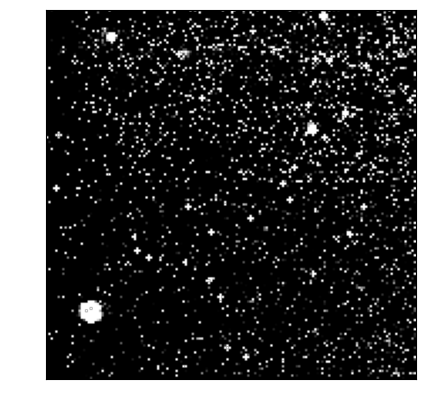

'jw01537024001_0310a_00001_nrcblong_cal.fits'

In [9]:
# Examine the First Image
ref_image = lvl2[0]
print(ref_image)
ref_fits = fits.open(ref_image)
ref_data = fits.open(ref_image)['SCI', 1].data
norm1 = simple_norm(ref_data, stretch='linear', min_cut=-1, max_cut=10)

plt.imshow(ref_data, origin='lower', norm=norm1, cmap='gray')
plt.gca().tick_params(labelcolor='none', axis='both', color='none')
plt.show()
lvl2[0]

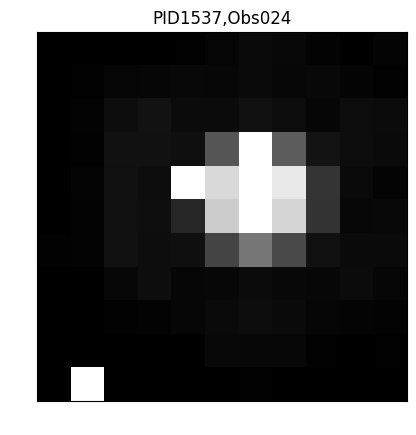

array([[-1.39843893e+01,             nan, -7.10014486e+00,
        -1.18051510e+01, -1.22078762e+01, -7.55733681e+00,
        -2.13549590e+00, -8.03505421e+00, -1.20125780e+01,
        -7.57162142e+00, -1.40897741e+01],
       [-8.80824947e+00, -1.50944538e+01, -8.38607407e+00,
        -1.30650015e+01, -6.26623774e+00,  2.16780949e+01,
         1.93335018e+01,  1.84923229e+01, -2.38547111e+00,
        -8.05991173e+00, -3.66179228e+00],
       [-8.69729900e+00, -1.05824366e+01, -1.91644752e+00,
         2.23856020e+00,  1.58385477e+01,  2.87495098e+01,
         3.98870125e+01,  3.08072701e+01,  1.16344948e+01,
         8.19910336e+00,  4.62944794e+00],
       [-1.64087601e+01, -8.50557709e+00,  2.11503353e+01,
         4.15567169e+01,  1.49958334e+01,  2.04633923e+01,
         3.47761116e+01,  2.32894917e+01,  1.85810509e+01,
         3.45461349e+01,  1.56002789e+01],
       [ 2.63730697e-02,  2.83913875e+00,  5.49829063e+01,
         4.31866798e+01,  4.97716103e+01,  2.61053589e+02,
  

In [10]:
# Zoom in to see the source
ref_y, ref_x = skycoord_to_pixel(source_location, wcs.WCS(ref_fits['SCI', 1], ref_fits))
ref_cutout = extract_array(ref_data, (11, 11), (ref_x, ref_y))
norm1 = simple_norm(ref_cutout, stretch='linear', min_cut=-10, max_cut=1000)
plt.imshow(ref_cutout, origin='lower',
           norm=norm1, cmap='gray')
plt.title('PID1537,Obs024')
plt.gca().tick_params(labelcolor='none', axis='both', color='none')
plt.show()

ref_cutout

Setting up sim to match jw01537024001_0310a_00001_nrcblong_cal.fits



MAST OPD query around UTC: 2022-09-08T10:35:01.135
                        MJD: 59830.44098535879

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022090801-NRCA3_FP1-1.fits
	Date (MJD):	 59829.7994
	Delta time:	 -0.6416 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022090902-NRCA3_FP1-1.fits
	Date (MJD):	 59831.6680
	Delta time:	 1.2270 days
User requested choosing OPD time closest in time to 2022-09-08T10:35:01.135, which is O2022090801-NRCA3_FP1-1.fits, delta time -0.642 days

 [Done]


Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022090801-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F444W
    Detector: NRCB5
    Apername: NRCB5_SUB160
    Det. Pos.: (80, 80) in subarray
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(27.79257472), array(18.3265345)) pixels


    Position 1/1 centroid: (121.61408244887103, 121.20038830234279)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(30.4215083), array(21.95448063)) pixels


    Position 1/1 centroid: (121.61425824086716, 121.20033209102951)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(122.74611417), array(15.00603225)) pixels


    Position 1/1 centroid: (121.61464275122991, 121.20874936410743)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(125.38672374), array(18.70671599)) pixels


    Position 1/1 centroid: (121.61474547983791, 121.20894011410664)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(27.69688493), array(138.379466)) pixels


    Position 1/1 centroid: (121.62031321487149, 121.19555321077925)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(30.31774438), array(141.96642009)) pixels


    Position 1/1 centroid: (121.62027405671115, 121.19573665868678)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(122.69274633), array(135.29495696)) pixels


    Position 1/1 centroid: (121.61911751843284, 121.20667407178158)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(125.31935628), array(138.93182751)) pixels


    Position 1/1 centroid: (121.61907288725097, 121.20713425404828)


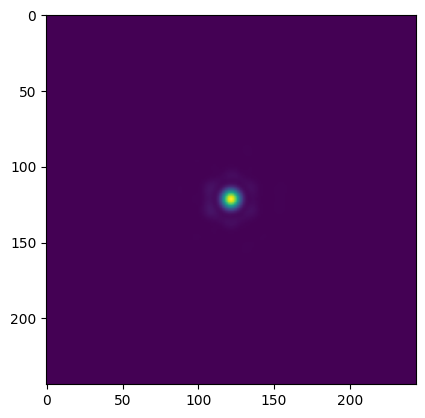

In [11]:
# Set environmental variables
os.environ["WEBBPSF_PATH"] = "./webbpsf-data/webbpsf-data"
os.environ["PYSYN_CDBS"] = "./grp/redcat/trds/"

# required webbpsf data
boxlink = 'https://stsci.box.com/shared/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz'                                                          
boxfile = './webbpsf-data/webbpsf-data-LATEST.tar.gz'
synphot_url = 'http://ssb.stsci.edu/trds/tarfiles/synphot5.tar.gz'
synphot_file = './synphot5.tar.gz'

webbpsf_folder = './webbpsf-data'
synphot_folder = './grp'


def download_file(url, dest_path, timeout=60):
    parsed_url = urlparse(url)
    if parsed_url.scheme not in ["http", "https"]:
        raise ValueError(f"Unsupported URL scheme: {parsed_url.scheme}")

    response = requests.get(url, stream=True, timeout=timeout)
    response.raise_for_status()
    with open(dest_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


# Gather webbpsf files
psfExist = os.path.exists(webbpsf_folder)
if not psfExist:
    os.makedirs(webbpsf_folder)
    download_file(boxlink, boxfile)
    gzf = tarfile.open(boxfile)
    gzf.extractall(webbpsf_folder, filter='data')

# Gather synphot files
synExist = os.path.exists(synphot_folder)
if not synExist:
    os.makedirs(synphot_folder)
    download_file(synphot_url, synphot_file)
    gzf = tarfile.open(synphot_file)
    gzf.extractall('./', filter='data')

# Get PSF from WebbPSF
jwst_obs = space_phot.observation2(lvl2)
psfs = space_phot.get_jwst_psf(jwst_obs, source_location)
plt.imshow(psfs[0].data)
plt.show()

Finished PSF psf_photometry with median residuals of 0.82%


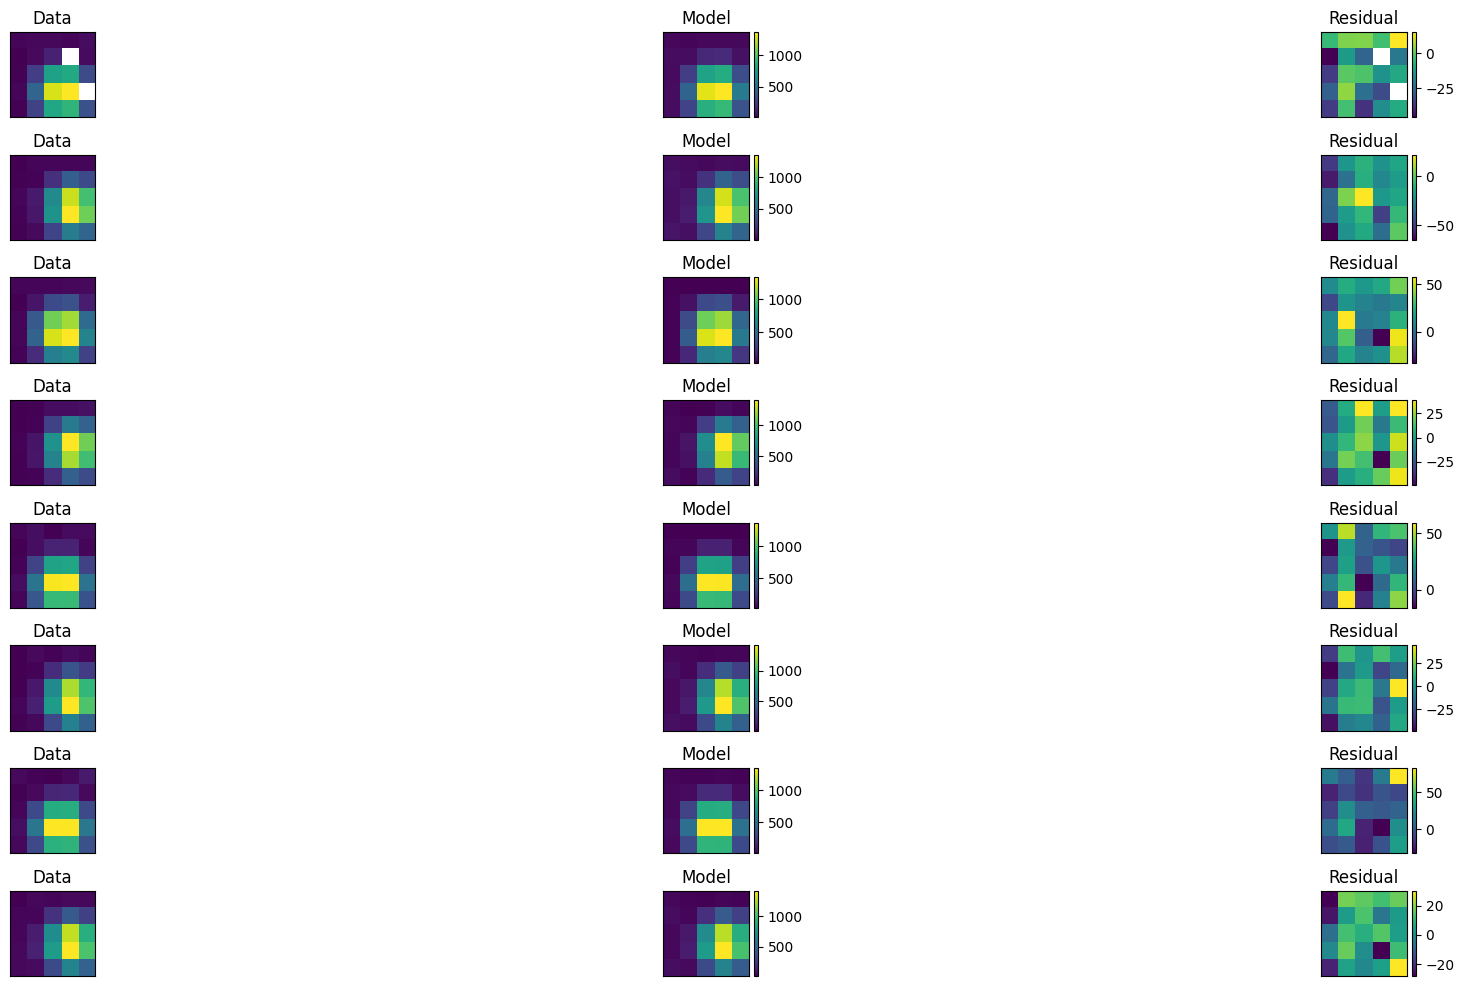

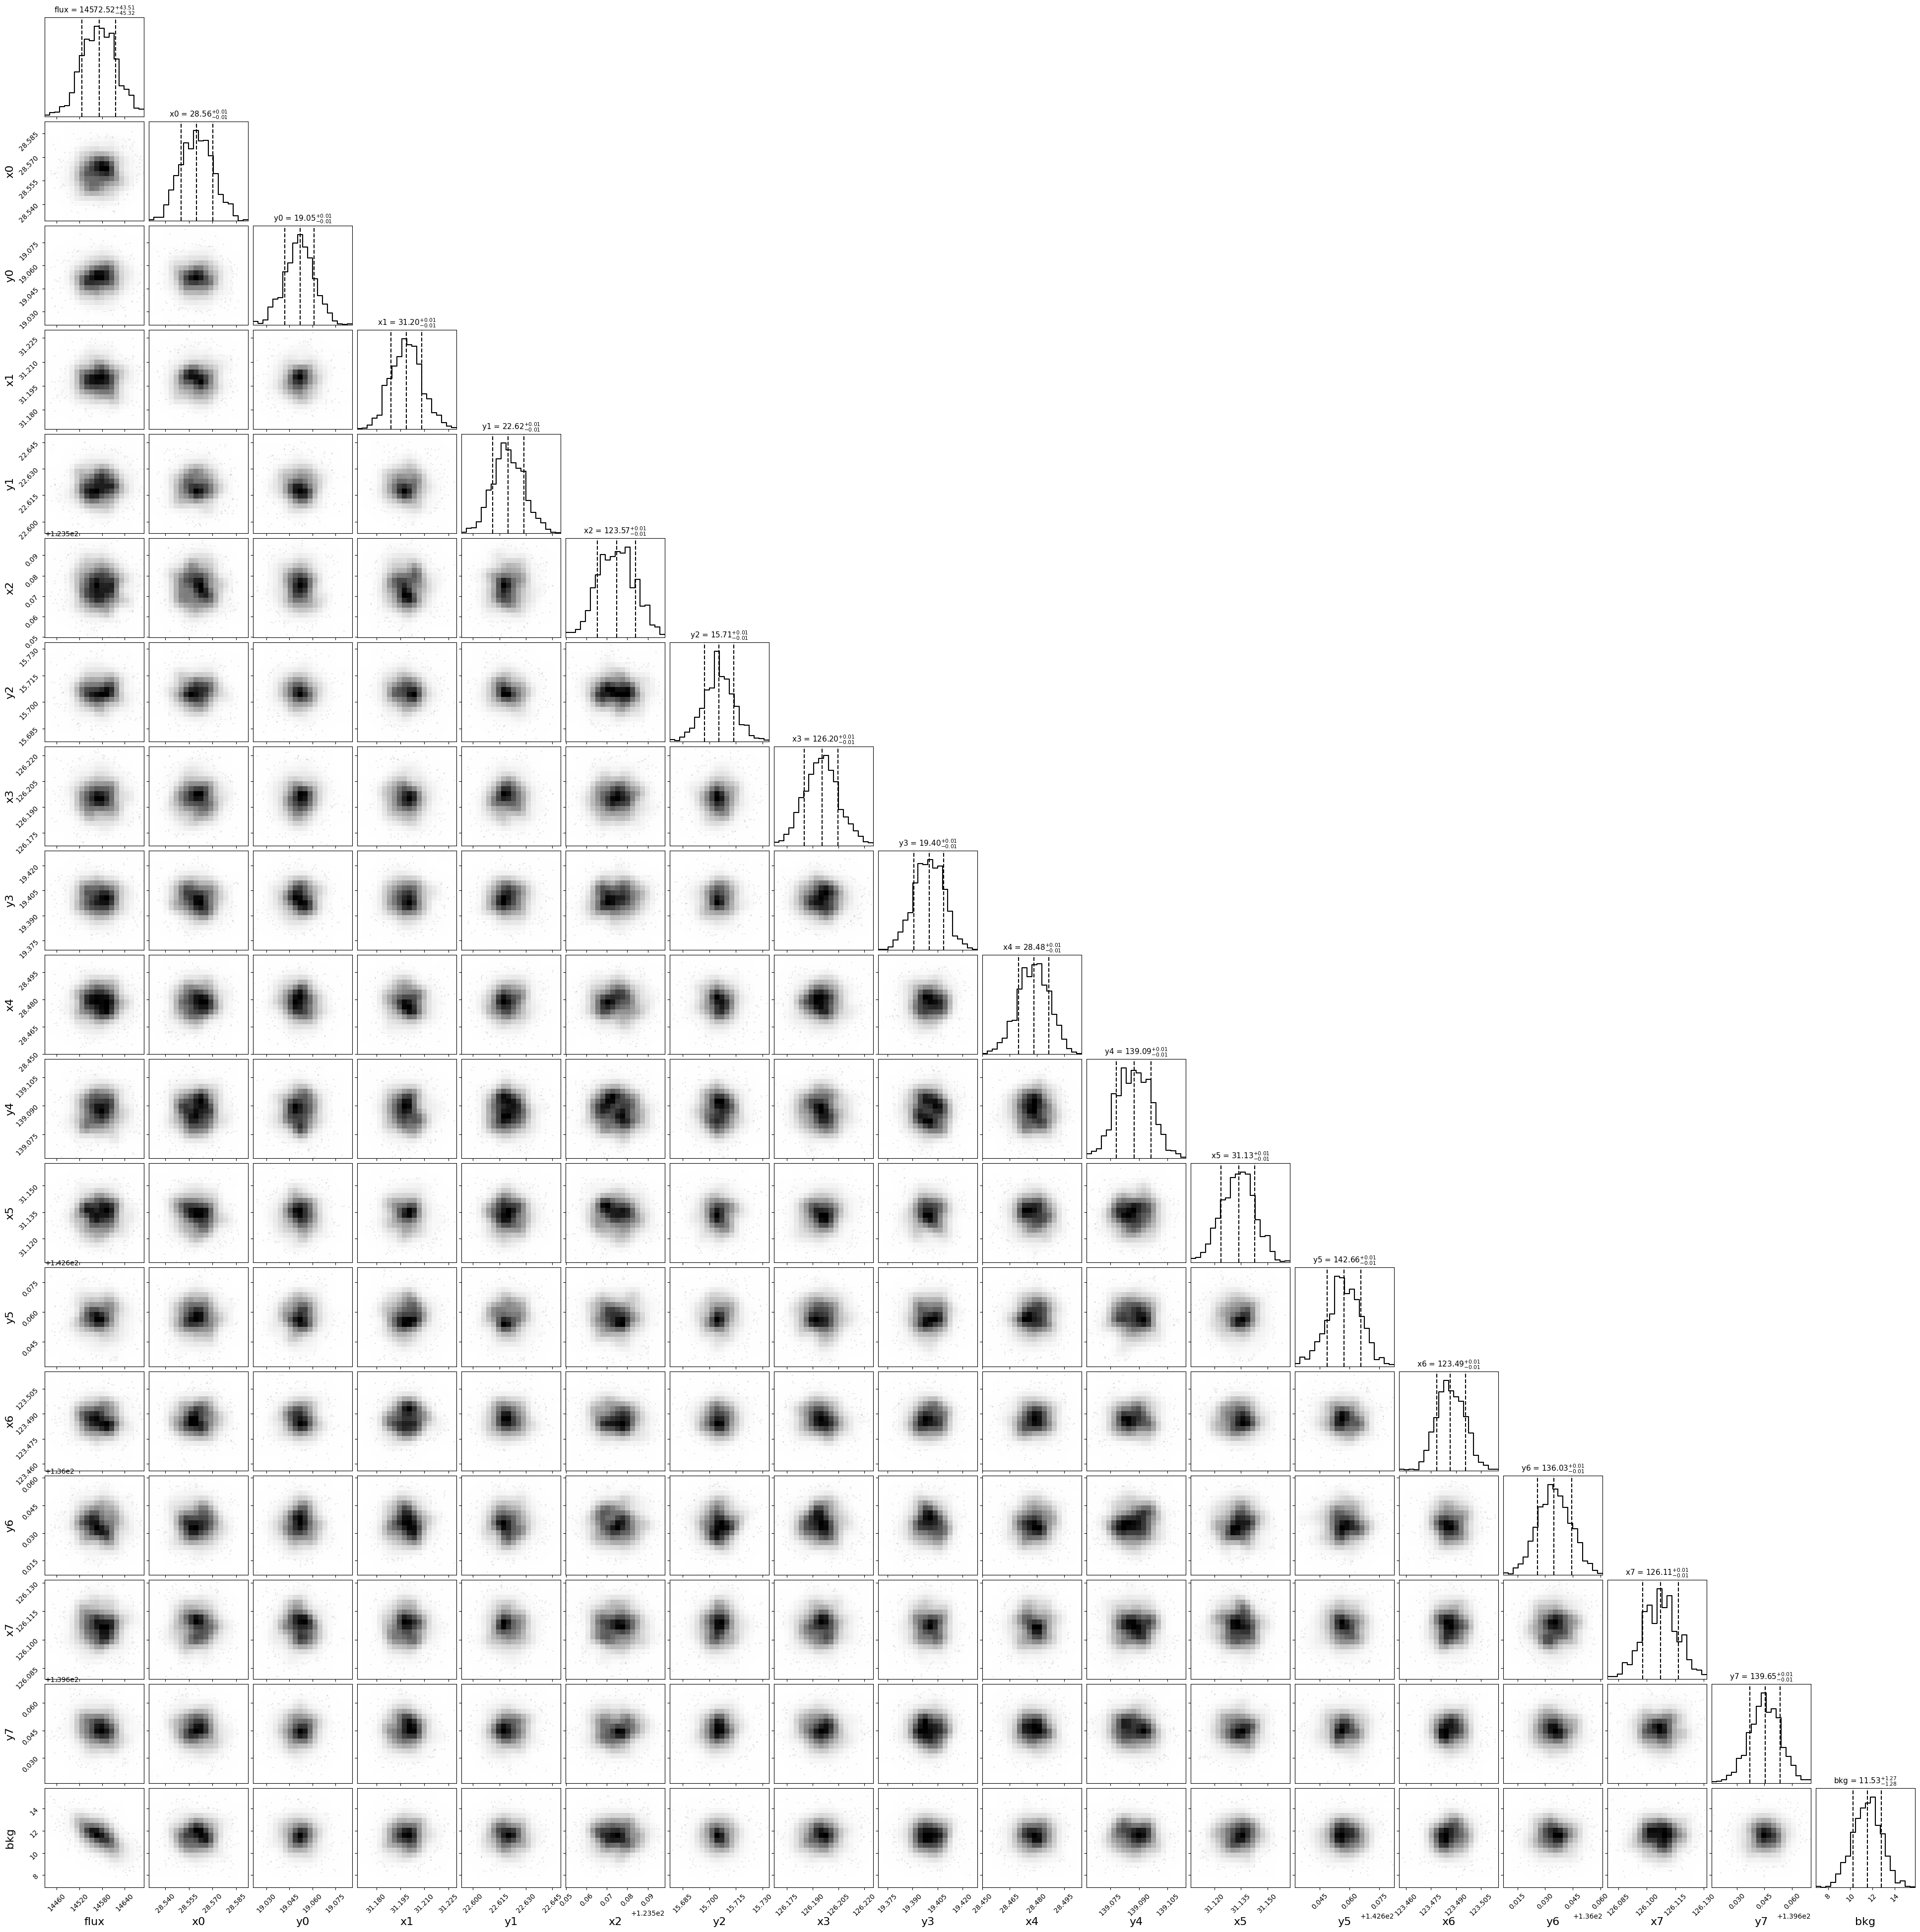

        ra        ...                     exp                    
----------------- ... -------------------------------------------
76.37772607500517 ... jw01537024001_0310a_00001_nrcblong_cal.fits
76.37772568129002 ... jw01537024001_0310a_00002_nrcblong_cal.fits
76.37772429510467 ... jw01537024001_0310a_00003_nrcblong_cal.fits
76.37772486661012 ... jw01537024001_0310a_00004_nrcblong_cal.fits
76.37772562830823 ... jw01537024001_0310k_00001_nrcblong_cal.fits
 76.3777246007601 ... jw01537024001_0310k_00002_nrcblong_cal.fits
76.37772534548797 ... jw01537024001_0310k_00003_nrcblong_cal.fits
76.37772549357817 ... jw01537024001_0310k_00004_nrcblong_cal.fits


In [12]:
# Do PSF Photometry using space_phot (details of fitting are in documentation)
# https://st-phot.readthedocs.io/en/latest/examples/plot_a_psf.html#jwst-images
jwst_obs.psf_photometry(psfs, source_location, bounds={'flux': [-10, 10000],
                        'centroid': [-2, 2],
                        'bkg': [0, 50]},
                        fit_width=5,
                        fit_bkg=True,
                        fit_flux='single')
jwst_obs.plot_psf_fit()
plt.show()

jwst_obs.plot_psf_posterior(minweight=.0005)
plt.show()

print(jwst_obs.psf_result.phot_cal_table)

In [13]:
# Calculate Average Magnitude from Table
mag_arr = jwst_obs.psf_result.phot_cal_table['mag']
magerr_arr = jwst_obs.psf_result.phot_cal_table['magerr']

mag_lvl2psf = np.mean(mag_arr)
magerr_lvl2psf = math.sqrt(sum(p**2 for p in magerr_arr))
print(round(mag_lvl2psf, 4), round(magerr_lvl2psf, 4))

16.0712 0.0098


4.<font color='white'>-</font>Faint/Upper Limit, Single Object<a class="anchor" id="fso"></a>
------------------

### 4.1<font color='white'>-</font>Multiple, Level2 Files<a class="anchor" id="fso2"></a> ###

In [14]:
# Level 3 Files
lvl3 = 'jw01537-o024_t001_nircam_clear-f444w-sub160_i2d.fits'
lvl3

'jw01537-o024_t001_nircam_clear-f444w-sub160_i2d.fits'

In [15]:
from jwst.associations import load_asn
hdl = fits.open(lvl3)
hdr = hdl[0].header
asnfile = hdr['ASNTABLE']
lvl2_prelim = []
asn_data = load_asn(open(asnfile))
for member in asn_data['products'][0]['members']:
    lvl2_prelim.append(member['expname'])
    
lvl2_prelim

['jw01537024001_0310a_00001_nrcblong_cal.fits',
 'jw01537024001_0310a_00002_nrcblong_cal.fits',
 'jw01537024001_0310a_00003_nrcblong_cal.fits',
 'jw01537024001_0310a_00004_nrcblong_cal.fits',
 'jw01537024001_0310k_00001_nrcblong_cal.fits',
 'jw01537024001_0310k_00002_nrcblong_cal.fits',
 'jw01537024001_0310k_00003_nrcblong_cal.fits',
 'jw01537024001_0310k_00004_nrcblong_cal.fits']

In [16]:
# Sort out LVL2 Data That Includes The Actual Source (there are 4 detectors)
source_location = SkyCoord('5:05:30.6186', '+52:49:49.130', unit=(u.hourangle, u.deg))
lvl2 = []
for ref_image in lvl2_prelim:
    print(ref_image)
    ref_fits = fits.open(ref_image)
    ref_data = fits.open(ref_image)['SCI', 1].data
    ref_y, ref_x = skycoord_to_pixel(source_location, wcs.WCS(ref_fits['SCI', 1], ref_fits))
    print(ref_y, ref_x)
    try:
        extract_array(ref_data, (11, 11), (ref_x, ref_y)) # block raising an exception
    except Exception as e:
        logging.error(f"An error occurred: {e}")
        pass  # Doing nothing on exception, but logging it
    else:
        lvl2.append(ref_image)
        print(ref_image + ' added to final list')
        
lvl2

jw01537024001_0310a_00001_nrcblong_cal.fits
29.578191133711194 34.311173060980174
jw01537024001_0310a_00001_nrcblong_cal.fits added to final list
jw01537024001_0310a_00002_nrcblong_cal.fits
33.20685297612088 36.94015519582315
jw01537024001_0310a_00002_nrcblong_cal.fits added to final list
jw01537024001_0310a_00003_nrcblong_cal.fits
26.267806097938603 129.27762919764902
jw01537024001_0310a_00003_nrcblong_cal.fits added to final list
jw01537024001_0310a_00004_nrcblong_cal.fits
29.96922123776791 131.91827643089408
jw01537024001_0310a_00004_nrcblong_cal.fits added to final list
jw01537024001_0310k_00001_nrcblong_cal.fits
149.64538227735872 34.20512634324998
jw01537024001_0310k_00001_nrcblong_cal.fits added to final list
jw01537024001_0310k_00002_nrcblong_cal.fits
153.23305507146313 36.826021255675926
jw01537024001_0310k_00002_nrcblong_cal.fits added to final list
jw01537024001_0310k_00003_nrcblong_cal.fits
146.5710722239996 129.2138637655567
jw01537024001_0310k_00003_nrcblong_cal.fits adde

['jw01537024001_0310a_00001_nrcblong_cal.fits',
 'jw01537024001_0310a_00002_nrcblong_cal.fits',
 'jw01537024001_0310a_00003_nrcblong_cal.fits',
 'jw01537024001_0310a_00004_nrcblong_cal.fits',
 'jw01537024001_0310k_00001_nrcblong_cal.fits',
 'jw01537024001_0310k_00002_nrcblong_cal.fits',
 'jw01537024001_0310k_00003_nrcblong_cal.fits',
 'jw01537024001_0310k_00004_nrcblong_cal.fits']

In [17]:
# Change all DQ flagged pixels to NANs
for file in lvl2:
    hdul = fits.open(file, mode='update')
    data = fits.open(file)['SCI', 1].data
    dq = fits.open(file)['DQ', 1].data
    data[dq == 1] = np.nan
    hdul['SCI', 1].data = data
    hdul.flush()

jw01537024001_0310a_00001_nrcblong_cal.fits


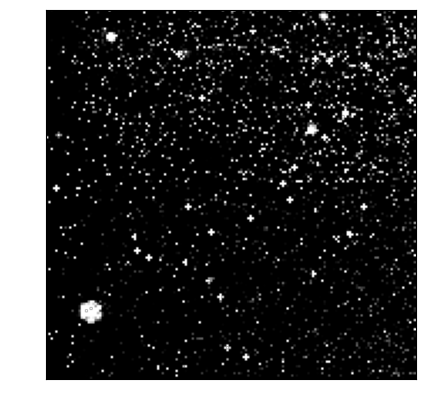

In [18]:
# Examine the First Image
ref_image = lvl2[0]
print(ref_image)
ref_fits = fits.open(ref_image)
ref_data = fits.open(ref_image)['SCI', 1].data
norm1 = simple_norm(ref_data, stretch='linear', min_cut=-1, max_cut=25)

plt.imshow(ref_data, origin='lower', norm=norm1, cmap='gray')
plt.gca().tick_params(labelcolor='none', axis='both', color='none')
plt.show()

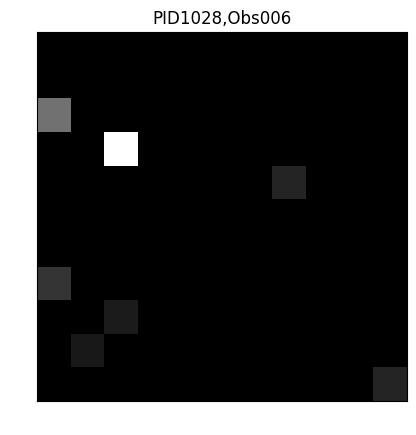

In [19]:
# Pick a blank part of the sky to calculate the upper limit
ref_y, ref_x = skycoord_to_pixel(source_location, wcs.WCS(ref_fits['SCI', 1], ref_fits))
ref_cutout = extract_array(ref_data, (11, 11), (ref_x, ref_y))
norm1 = simple_norm(ref_cutout, stretch='linear', min_cut=-1, max_cut=25)
plt.imshow(ref_cutout, origin='lower',
           norm=norm1, cmap='gray')
plt.title('PID1028,Obs006')
plt.gca().tick_params(labelcolor='none', axis='both', color='none')
plt.show()

Setting up sim to match jw01537024001_0310a_00001_nrcblong_cal.fits



MAST OPD query around UTC: 2022-09-08T10:35:01.135
                        MJD: 59830.44098535879

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022090801-NRCA3_FP1-1.fits
	Date (MJD):	 59829.7994
	Delta time:	 -0.6416 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022090902-NRCA3_FP1-1.fits
	Date (MJD):	 59831.6680
	Delta time:	 1.2270 days
User requested choosing OPD time closest in time to 2022-09-08T10:35:01.135, which is O2022090801-NRCA3_FP1-1.fits, delta time -0.642 days
Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022090801-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F444W
    Detector: NRCB5
    Apername: NRCB5_SUB160
    Det. Pos.: (80, 80) in subarray
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(34.31117306), array(29.57819113)) pixels


    Position 1/1 centroid: (121.61475856280782, 121.19999121330285)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(36.9401552), array(33.20685298)) pixels


    Position 1/1 centroid: (121.61503716739294, 121.19984303983951)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(129.2776292), array(26.2678061)) pixels


    Position 1/1 centroid: (121.61508045221416, 121.20903132936235)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(131.91827643), array(29.96922124)) pixels


    Position 1/1 centroid: (121.61523511808892, 121.20913828125003)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(34.20512634), array(149.64538228)) pixels


    Position 1/1 centroid: (121.62019174224973, 121.19591314061994)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(36.82602126), array(153.23305507)) pixels


    Position 1/1 centroid: (121.62012670336671, 121.19601217585985)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(129.21386377), array(146.57107222)) pixels


    Position 1/1 centroid: (121.61893086748388, 121.20780845600966)

Running instrument: NIRCam, filter: F444W
  Running detector: NRCB5
    Position 1/1: (array(131.84050451), array(150.2086708)) pixels


    Position 1/1 centroid: (121.61884045072581, 121.20815277056805)


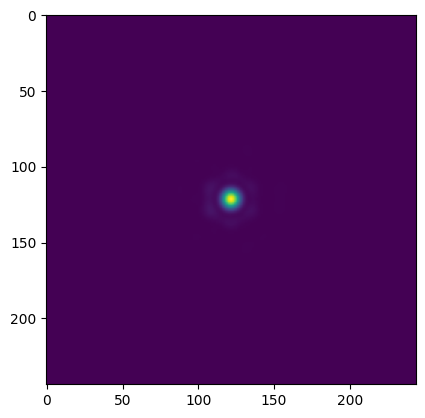

In [20]:
# Get PSF from WebbPSF
jwst_obs = space_phot.observation2(lvl2)
psfs = space_phot.get_jwst_psf(jwst_obs, source_location)
plt.imshow(psfs[0].data)
plt.show()

Finished PSF psf_photometry with median residuals of 95.14%


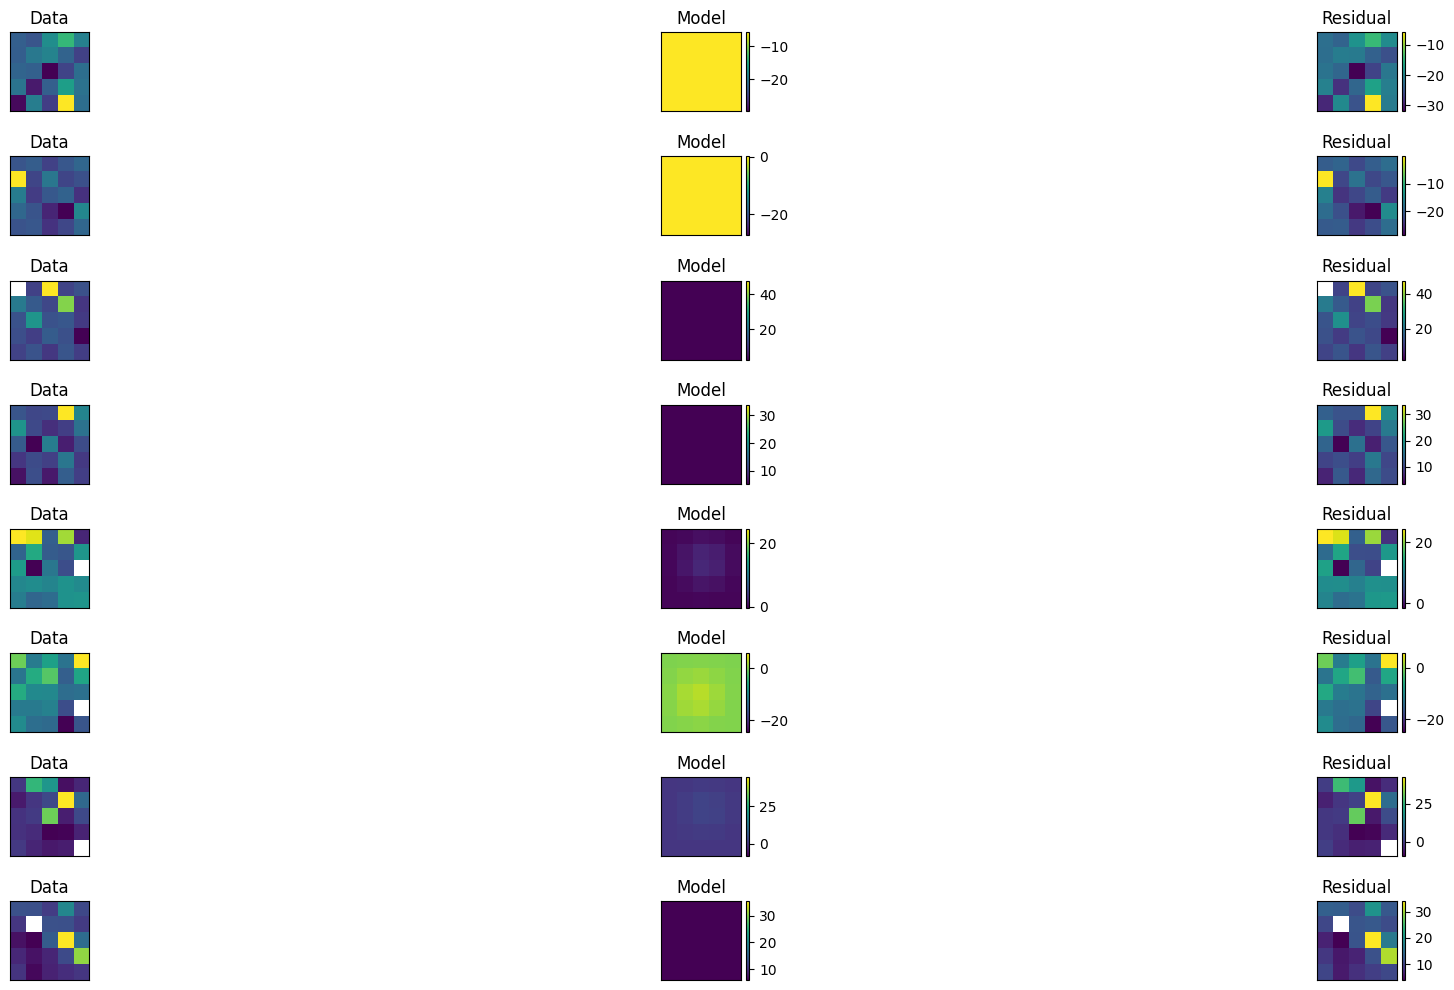

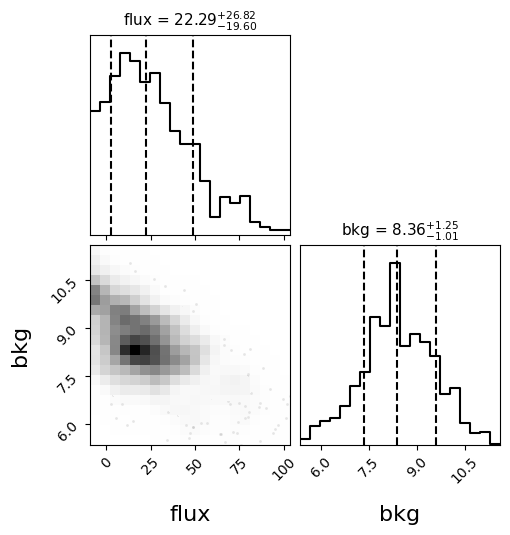

        ra        ...                     exp                    
----------------- ... -------------------------------------------
76.37757749999973 ... jw01537024001_0310a_00001_nrcblong_cal.fits
76.37757749999979 ... jw01537024001_0310a_00002_nrcblong_cal.fits
 76.3775774999995 ... jw01537024001_0310a_00003_nrcblong_cal.fits
76.37757749999939 ... jw01537024001_0310a_00004_nrcblong_cal.fits
76.37757749999984 ... jw01537024001_0310k_00001_nrcblong_cal.fits
76.37757750000006 ... jw01537024001_0310k_00002_nrcblong_cal.fits
76.37757749999902 ... jw01537024001_0310k_00003_nrcblong_cal.fits
 76.3775774999988 ... jw01537024001_0310k_00004_nrcblong_cal.fits


In [21]:
# Do PSF Photometry using space_phot (details of fitting are in documentation)
# https://st-phot.readthedocs.io/en/latest/examples/plot_a_psf.html#jwst-images
jwst_obs.psf_photometry(
    psfs,
    source_location,
    bounds={
        'flux': [-10, 1000],
        'bkg': [0, 50]
    },
    fit_width=5,
    fit_bkg=True,
    fit_centroid='fixed',
    fit_flux='single'
)

jwst_obs.plot_psf_fit()
plt.show()

jwst_obs.plot_psf_posterior(minweight=.0005)
plt.show()

print(jwst_obs.psf_result.phot_cal_table)

In [22]:
# Print Upper Limits
magupper_lvl2psf = jwst_obs.upper_limit(nsigma=5)
magupper_lvl2psf

array([21.28818331, 21.28818331, 21.28818331, 21.28818331, 21.2881833 ,
       21.2881833 , 21.2881833 , 21.2881833 ])

5.<font color='white'>-</font>Stellar Field (LMC)<a class="anchor" id="lmc"></a>
------------------

### 5.1<font color='white'>-</font>Multiple, Level2 Files<a class="anchor" id="lmc2"></a> ###

##### Now do the same thing for a larger group of stars and test for speed

In [23]:
# Level 3 Files: NIRCam Data PID 1476 (LMC)
lvl3 = 'jw01476-o001_t001_nircam_clear-f150w_i2d.fits'
lvl3

'jw01476-o001_t001_nircam_clear-f150w_i2d.fits'

In [24]:
hdl = fits.open(lvl3)
hdr = hdl[0].header
asnfile = hdr['ASNTABLE']
lvl2 = []
asn_data = load_asn(open(asnfile))
for member in asn_data['products'][0]['members']:
    lvl2.append(member['expname'])
    
lvl2 = [s for s in lvl2 if "nrca1" in s]
lvl2

['jw01476001007_02101_00001_nrca1_cal.fits',
 'jw01476001007_02101_00002_nrca1_cal.fits',
 'jw01476001007_02101_00003_nrca1_cal.fits',
 'jw01476001008_02101_00001_nrca1_cal.fits',
 'jw01476001008_02101_00002_nrca1_cal.fits',
 'jw01476001008_02101_00003_nrca1_cal.fits',
 'jw01476001008_02101_00004_nrca1_cal.fits',
 'jw01476001008_02101_00005_nrca1_cal.fits',
 'jw01476001008_02101_00006_nrca1_cal.fits']

In [25]:
# Find Stars in Level 3 File
# Get rough estimate of background (There are Better Ways to Do Background Subtraction)
bkgrms = MADStdBackgroundRMS()
mmm_bkg = MMMBackground()

im = fits.open(lvl3) 
w = wcs.WCS(im['SCI', 1])

std = bkgrms(im[1].data)
bkg = mmm_bkg(im[1].data)
data_bkgsub = im[1].data.copy()
data_bkgsub -= bkg        
sigma_psf = 1.636 # pixls for F770W
threshold = 5.

daofind = DAOStarFinder(threshold=threshold * std, fwhm=sigma_psf, exclude_border=True)
found_stars = daofind(data_bkgsub)

In [26]:
found_stars.pprint_all(max_lines=10)

  id       xcentroid          ycentroid         sharpness       roundness1       roundness2       npix sky        peak               flux                mag        
------ ------------------ ----------------- ------------------ ----------- ---------------------- ---- --- ------------------ ------------------ -------------------
     1  2313.311806426347 7.428673613288881 0.7464983792041037 -0.36265197 -0.0019793827252529922   25 0.0  42.87360382080078 10.740928649902344  -2.577604579128796
     2 2344.5489097175423  9.12325132865925 0.7774905165179704  -0.5229934    -0.2107895776135414   25 0.0  6.612555980682373 1.8123060464859009 -0.6455788485240265
     3 2560.7036187851127  9.08247575871399 0.7469957136061309 -0.20123233  -0.021288724925038794   25 0.0 22.579843521118164  5.954031944274902 -1.9370279009300662
   ...                ...               ...                ...         ...                    ...  ... ...                ...                ...                 ...
176101 112

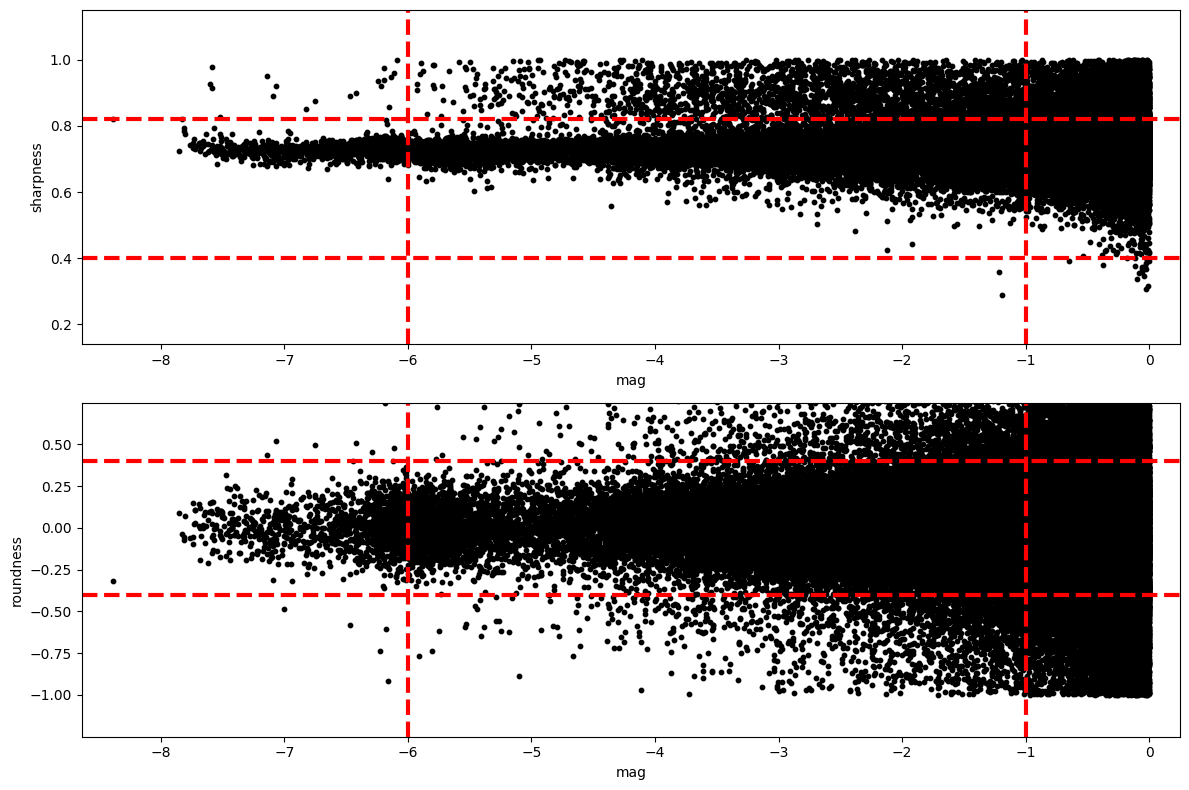

In [27]:
# Filter out only stars you want
plt.figure(figsize=(12, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel('mag')
ax1.set_ylabel('sharpness')

xlim0 = np.min(found_stars['mag']) - 0.25
xlim1 = np.max(found_stars['mag']) + 0.25
ylim0 = np.min(found_stars['sharpness']) - 0.15
ylim1 = np.max(found_stars['sharpness']) + 0.15

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.scatter(found_stars['mag'], found_stars['sharpness'], s=10, color='k')

sh_inf = 0.40
sh_sup = 0.82
lmag_lim = -1.0
umag_lim = -6.0

ax1.plot([xlim0, xlim1], [sh_sup, sh_sup], color='r', lw=3, ls='--')
ax1.plot([xlim0, xlim1], [sh_inf, sh_inf], color='r', lw=3, ls='--')
ax1.plot([lmag_lim, lmag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')
ax1.plot([umag_lim, umag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')

ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel('mag')
ax2.set_ylabel('roundness')

ylim0 = np.min(found_stars['roundness2']) - 0.25
ylim1 = np.max(found_stars['roundness2']) - 0.25

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

round_inf = -0.40
round_sup = 0.40

ax2.scatter(found_stars['mag'], found_stars['roundness2'], s=10, color='k')

ax2.plot([xlim0, xlim1], [round_sup, round_sup], color='r', lw=3, ls='--')
ax2.plot([xlim0, xlim1], [round_inf, round_inf], color='r', lw=3, ls='--')
ax2.plot([lmag_lim, lmag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')
ax2.plot([umag_lim, umag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')

plt.tight_layout()

In [28]:
mask = ((found_stars['mag'] < lmag_lim) & (found_stars['mag'] > umag_lim) & (found_stars['roundness2'] > round_inf)
        & (found_stars['roundness2'] < round_sup) & (found_stars['sharpness'] > sh_inf) 
        & (found_stars['sharpness'] < sh_sup) & (found_stars['xcentroid'] > 1940) & (found_stars['xcentroid'] < 2000)
        & (found_stars['ycentroid'] > 1890) & (found_stars['ycentroid'] < 1960))

found_stars_sel = found_stars[mask]

print('Number of stars found originally:', len(found_stars))
print('Number of stars in final selection:', len(found_stars_sel))

Number of stars found originally: 176103
Number of stars in final selection: 4


In [29]:
found_stars_sel

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float32,float64,int64,float64,float64,float64,float64
54674,1946.01587362572,1931.825951504941,0.7395550115918611,-0.029228194,0.01395382327238304,25,0.0,60.01284408569336,15.238639831542969,-2.957365511338107
54788,1946.4225358750648,1935.800642680752,0.77014000792855,-0.49607933,0.18925856133576408,25,0.0,11.186165809631348,2.596914052963257,-1.0361439413225255
55124,1997.691121306392,1946.8426414908845,0.7590852154784529,0.00070239697,-0.04129153840403424,25,0.0,11.842576026916504,2.9808762073516846,-1.185859851537131
55478,1958.7425702916094,1959.0171575126099,0.7159049756315641,-0.25076354,-0.036393241922931,25,0.0,11.71850872039795,3.0322105884552,-1.2043983999100105


In [30]:
# Convert pixel to wcs coords
skycoords = w.pixel_to_world(found_stars_sel['xcentroid'], found_stars_sel['ycentroid'])
len(skycoords)

4

In [31]:
lvl2

['jw01476001007_02101_00001_nrca1_cal.fits',
 'jw01476001007_02101_00002_nrca1_cal.fits',
 'jw01476001007_02101_00003_nrca1_cal.fits',
 'jw01476001008_02101_00001_nrca1_cal.fits',
 'jw01476001008_02101_00002_nrca1_cal.fits',
 'jw01476001008_02101_00003_nrca1_cal.fits',
 'jw01476001008_02101_00004_nrca1_cal.fits',
 'jw01476001008_02101_00005_nrca1_cal.fits',
 'jw01476001008_02101_00006_nrca1_cal.fits']

In [32]:
file = lvl2[0]
dq = fits.open(file)['DQ', 1].data
dq[233, 340]

0

In [33]:
# Change all DQ flagged pixels to NANs
for file in lvl2:
    hdul = fits.open(file, mode='update')
    data = fits.open(file)['SCI', 1].data
    dq = fits.open(file)['DQ', 1].data
    data[dq == 262657] = np.nan
    data[dq == 262661] = np.nan
    hdul['SCI', 1].data = data
    hdul.flush()

In [34]:
# Create a grid for fast lookup using WebbPSF. The larger the grid, the better the photometric precision.
# Developer note. Would be great to have a fast/approximate look up table.
jwst_obs = space_phot.observation2(lvl2)
grid = space_phot.util.get_jwst_psf_grid(jwst_obs, num_psfs=4)

Setting up sim to match jw01476001007_02101_00001_nrca1_cal.fits


iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-07-11T03:15:34.398
                        MJD: 59771.13581479167

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022071001-NRCA3_FP1-0.fits
	Date (MJD):	 59770.4830
	Delta time:	 -0.6529 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022071302-NRCA3_FP1-1.fits
	Date (MJD):	 59772.6632
	Delta time:	 1.5274 days
User requested choosing OPD time closest in time to 2022-07-11T03:15:34.398, which is O2022071001-NRCA3_FP1-0.fits, delta time -0.653 days


 [Done]


Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022071001-NRCA3_FP1-0.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F150W
    Detector: NRCA1
    Apername: NRCA1_FULL
    Det. Pos.: (1024, 1024) 
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/4: (0, 0) pixels


    Position 1/4 centroid: (201.21849572758828, 201.71204989920975)
    Position 2/4: (0, 2047) pixels


    Position 2/4 centroid: (201.47571369051525, 201.76630784134034)
    Position 3/4: (2047, 0) pixels


    Position 3/4 centroid: (201.25033871861956, 201.53013932680594)
    Position 4/4: (2047, 2047) pixels


    Position 4/4 centroid: (201.60882081144842, 201.4569860822112)
  Saving file: nircam_nrca1_f150w_fovp101_samp4_npsf4.fits


Starting 1.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36227052, -69.46233049)>


Finished PSF psf_photometry with median residuals of -0.91%


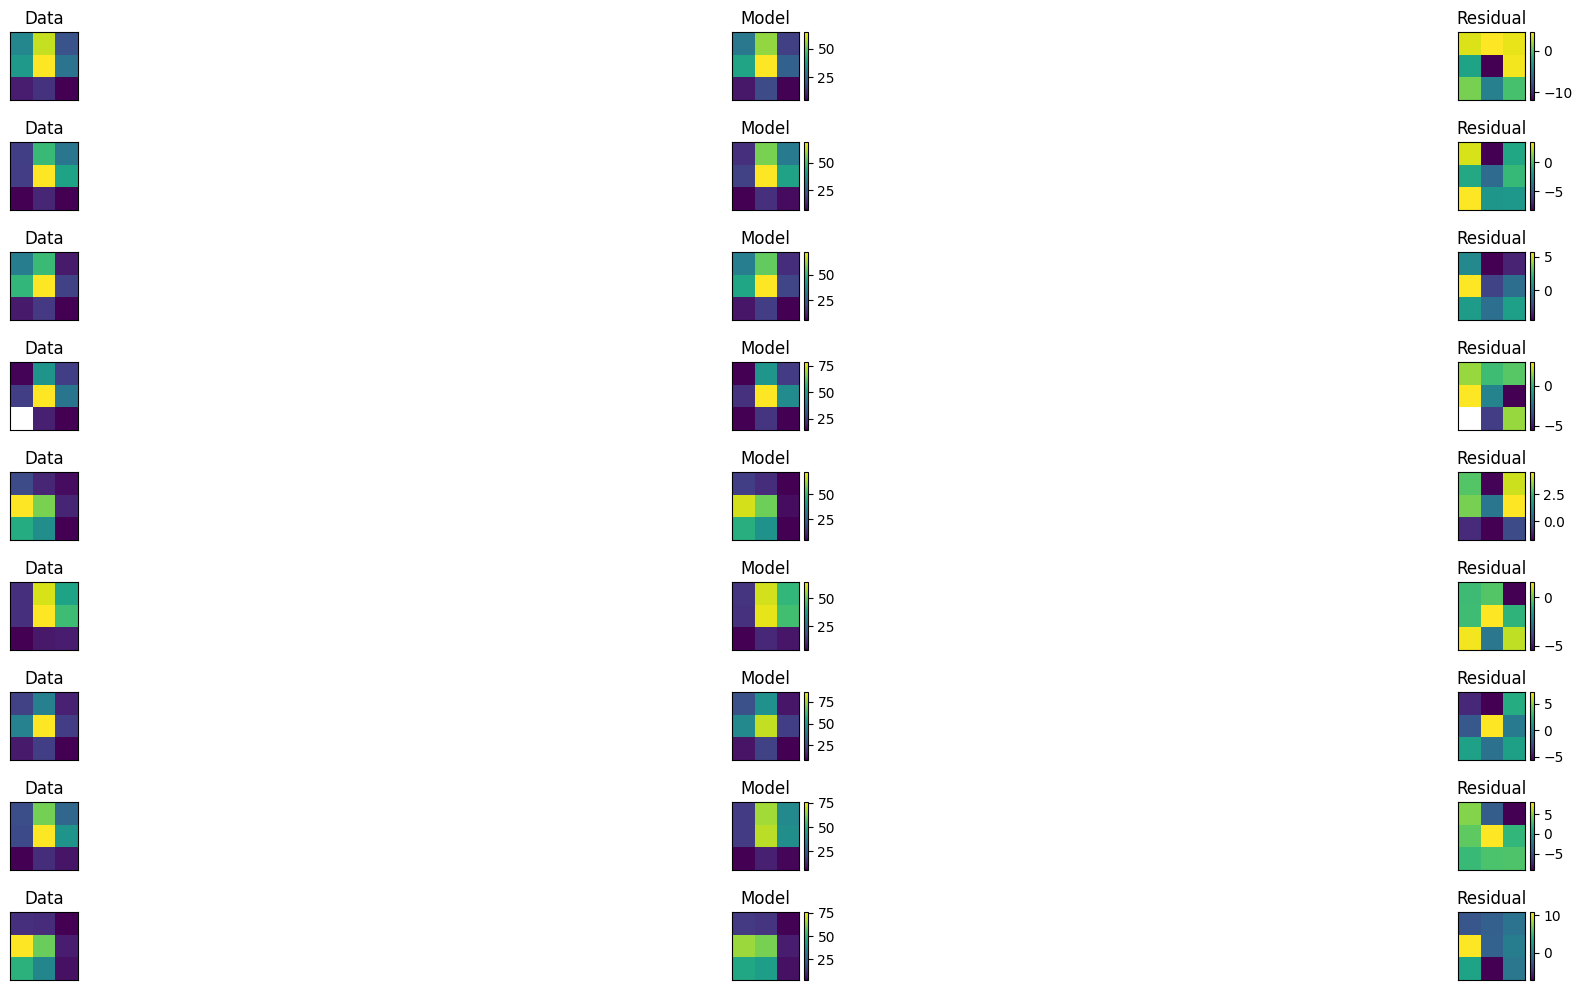

Elapsed Time for Photometry: 310.30858815600004
Starting 2.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36223231, -69.46236245)>


Finished PSF psf_photometry with median residuals of 7.15%


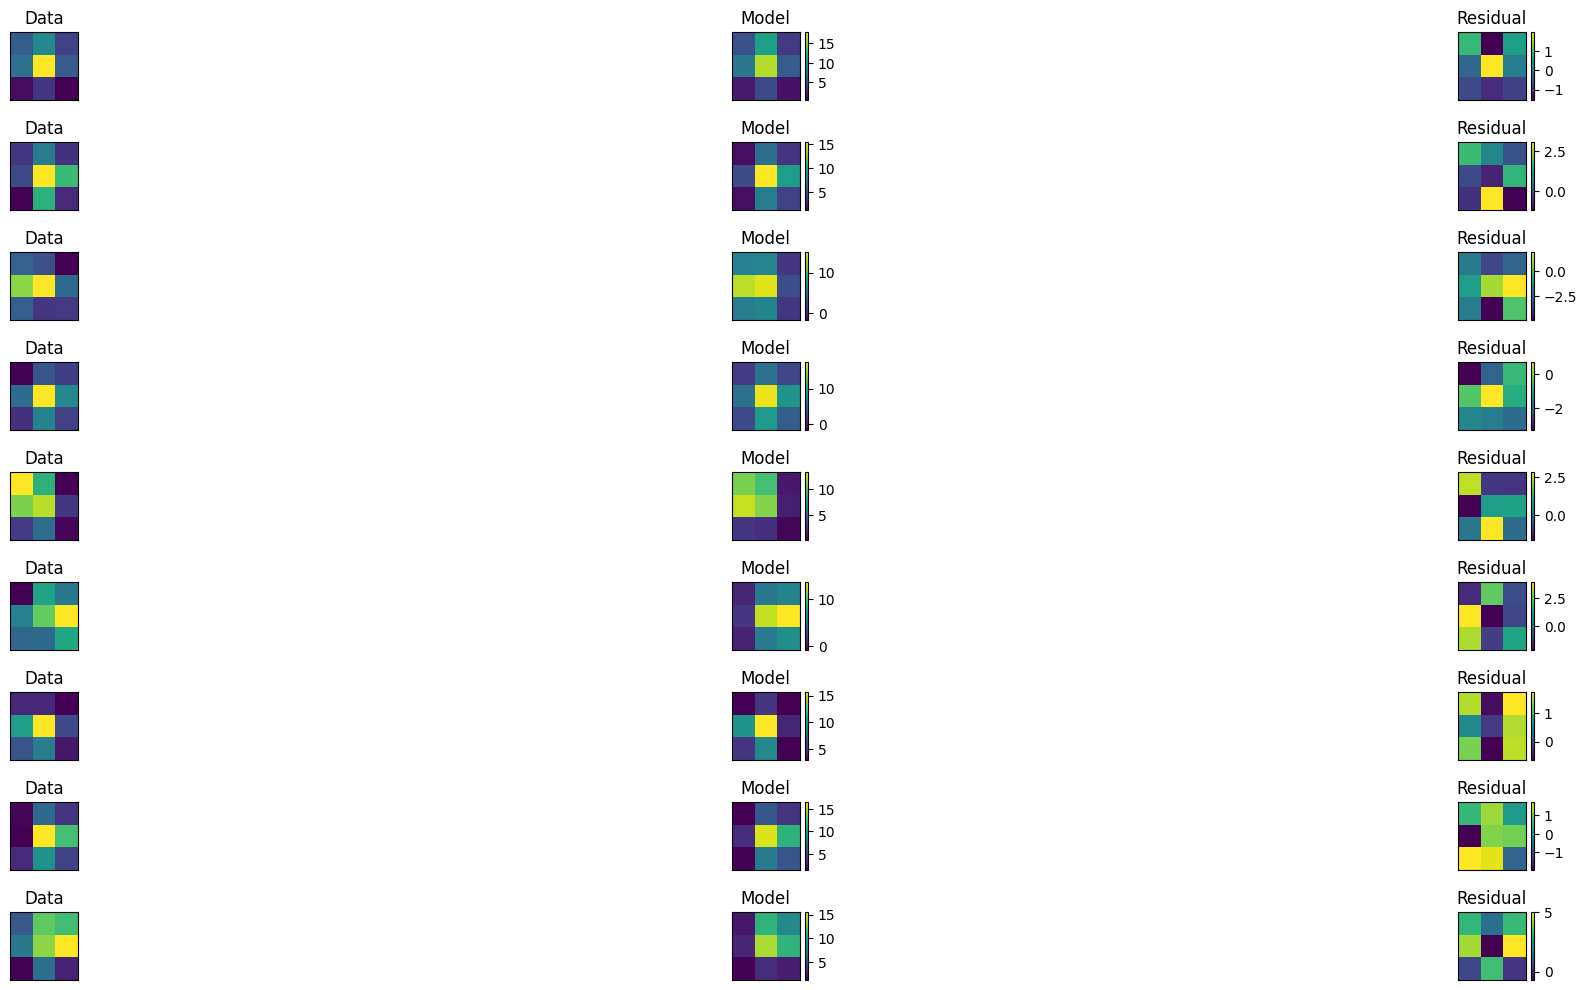

Elapsed Time for Photometry: 471.38267524899993
Starting 3.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36321461, -69.46265941)>


Finished PSF psf_photometry with median residuals of 3.79%


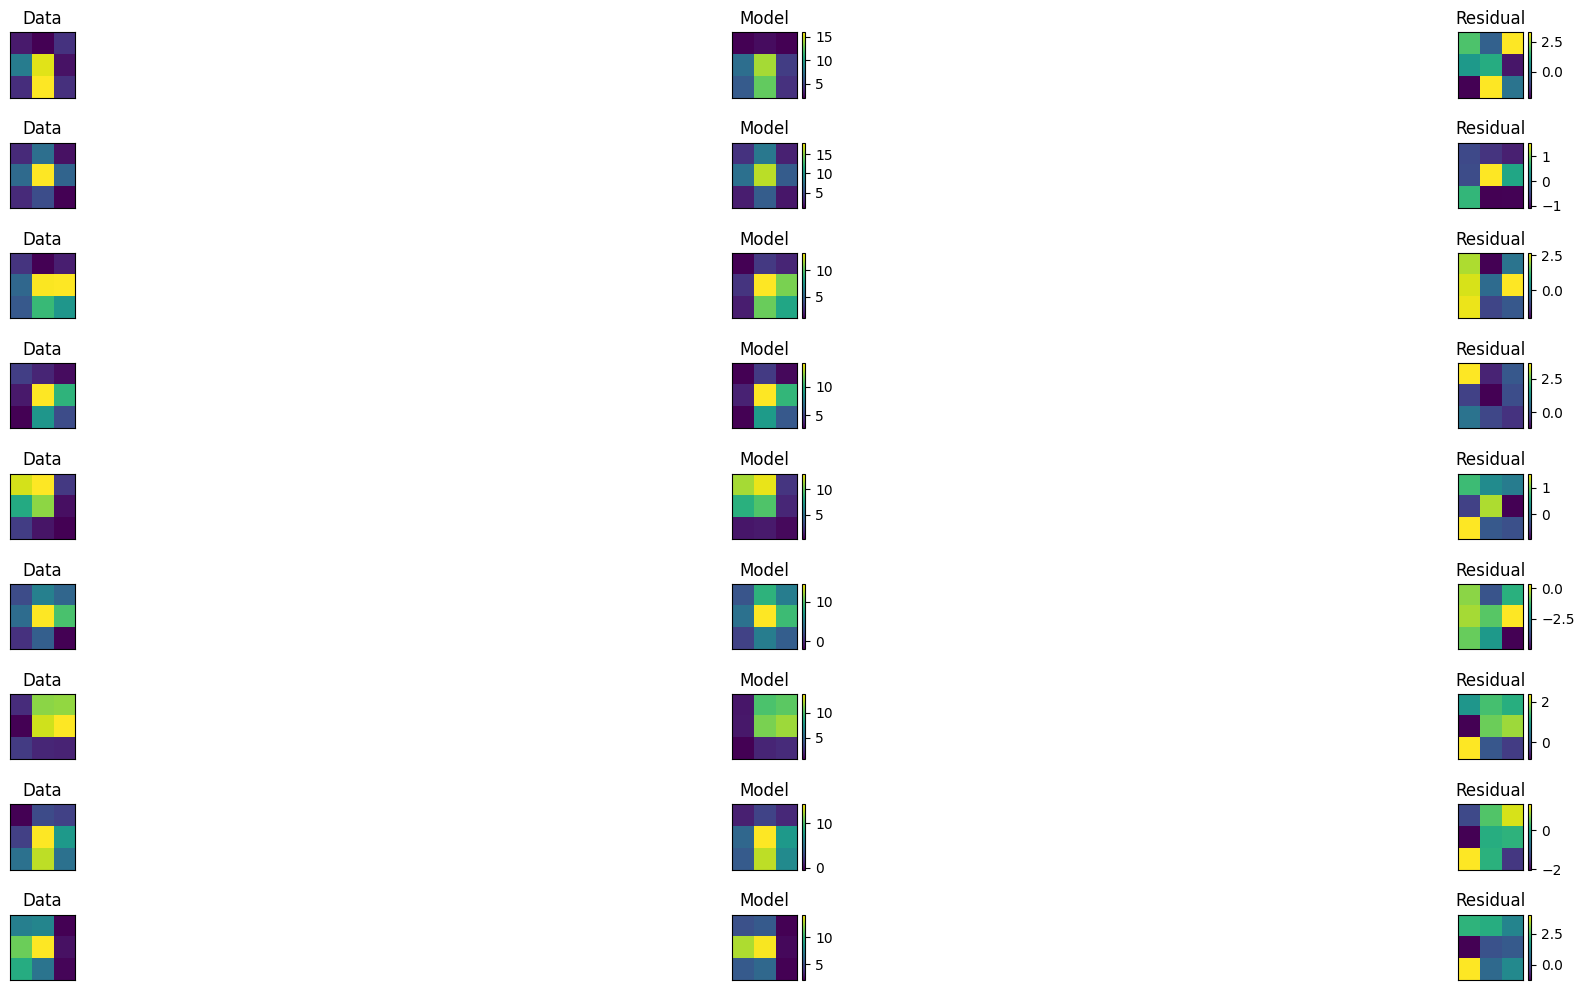

Elapsed Time for Photometry: 236.34491571900003
Starting 4.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36222499, -69.46259042)>


Finished PSF psf_photometry with median residuals of 4.54%


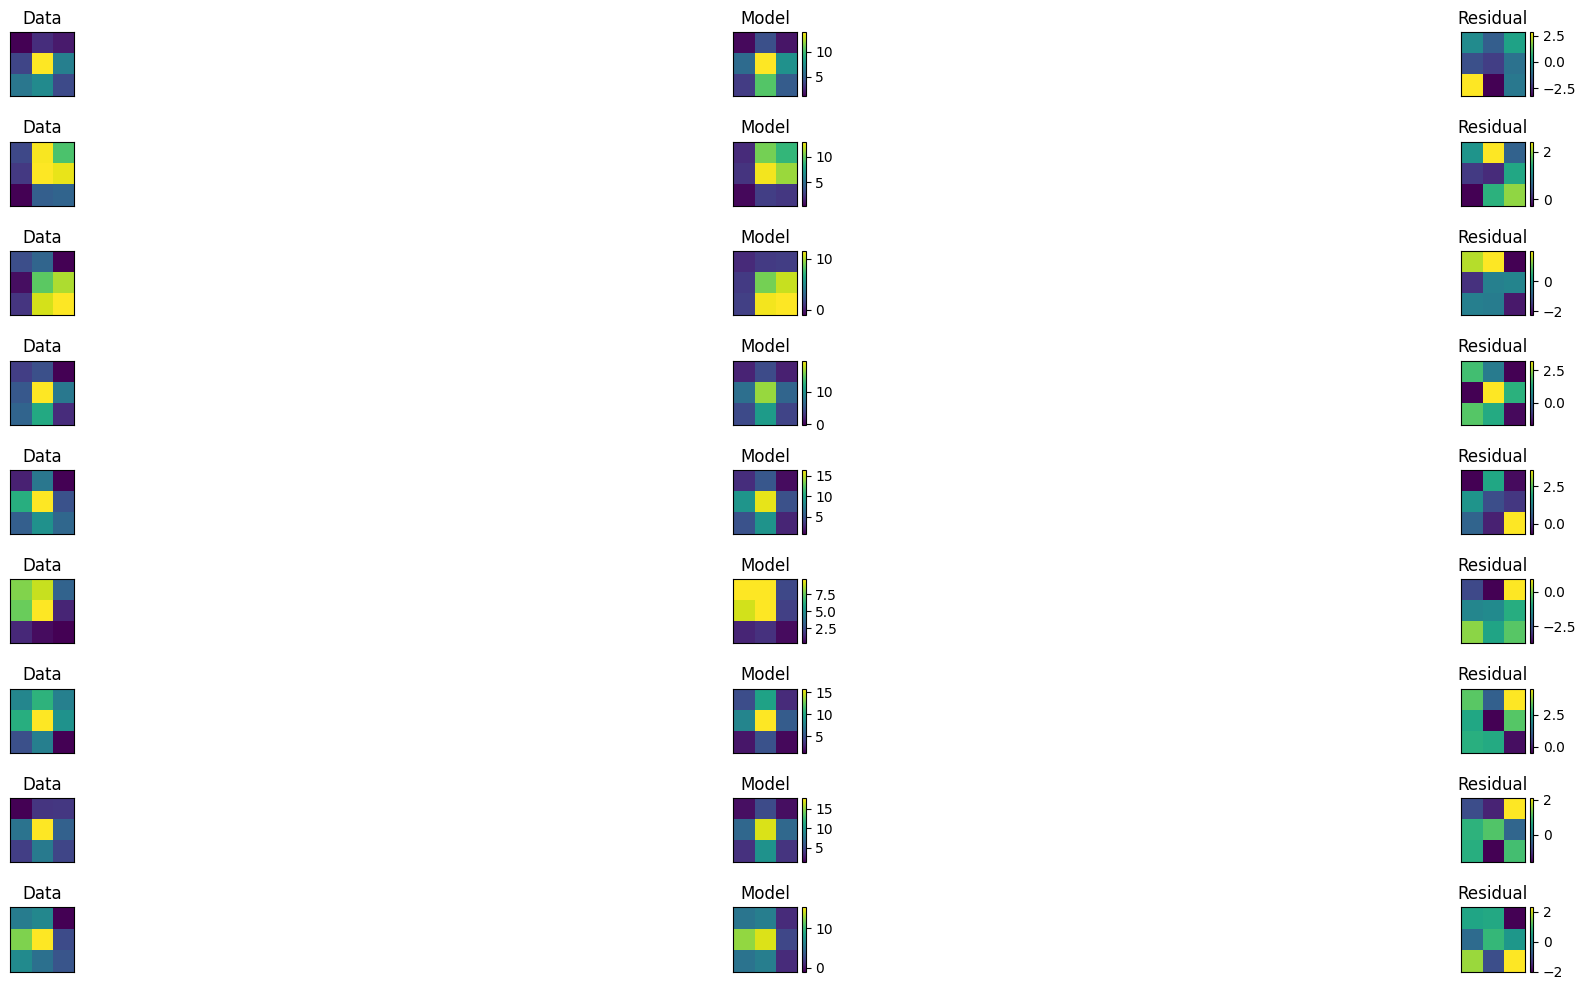

Elapsed Time for Photometry: 1273.0737063640001


In [35]:
# Now Loop Through All Stars and Build Photometry Table
counter = 0.
badindex = []

jwst_obs = space_phot.observation2(lvl2)
for source_location in skycoords:
    tic = time.perf_counter()
    print('Starting', counter+1., ' of', len(skycoords), ':', source_location)
    psfs = space_phot.util.get_jwst_psf_from_grid(jwst_obs, source_location, grid)
    jwst_obs.psf_photometry(
        psfs,
        source_location,
        bounds={
            'flux': [-100, 1000],
            'centroid': [-2., 2.],
            'bkg': [0, 50]
        },
        fit_width=3,
        fit_bkg=False,
        fit_flux='single',
        maxiter=5000
    )
    
    jwst_obs.plot_psf_fit()
    plt.show()
    
    ra = jwst_obs.psf_result.phot_cal_table['ra'][0]
    dec = jwst_obs.psf_result.phot_cal_table['dec'][0]
    mag_arr = jwst_obs.psf_result.phot_cal_table['mag']
    magerr_arr = jwst_obs.psf_result.phot_cal_table['magerr']
    mag_lvl2psf = np.mean(mag_arr)
    magerr_lvl2psf = math.sqrt(sum(p**2 for p in magerr_arr))

    if counter == 0:
        df = pd.DataFrame(np.array([[ra, dec, mag_lvl2psf, magerr_lvl2psf]]), columns=['ra', 'dec', 'mag', 'magerr'])
    else:
        df = pd.concat([df, pd.DataFrame(np.array([[ra, dec, mag_lvl2psf, magerr_lvl2psf]]))], ignore_index=True)
    counter = counter + 1.
    
    toc = time.perf_counter()
    print("Elapsed Time for Photometry:", toc - tic)

### 5.2<font color='white'>-</font>Single, Level3 Mosaicked File<a class="anchor" id="lmc3"></a> ###

In [36]:
lvl3

'jw01476-o001_t001_nircam_clear-f150w_i2d.fits'

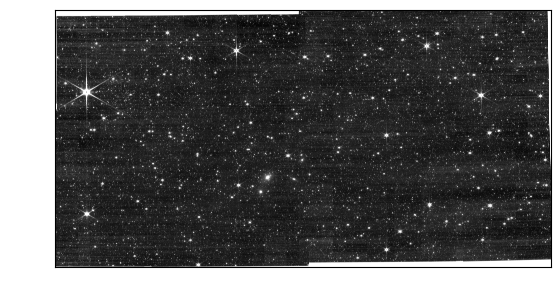

In [37]:
# Now do the same photometry on the Level 3 Data
ref_image = lvl3
ref_fits = fits.open(ref_image)
ref_data = fits.open(ref_image)['SCI', 1].data
norm1 = simple_norm(ref_data, stretch='linear', min_cut=-1, max_cut=10)

plt.imshow(ref_data, origin='lower',
           norm=norm1, cmap='gray')
plt.gca().tick_params(labelcolor='none', axis='both', color='none')
plt.show()

In [38]:
# Get PSF from WebbPSF and drizzle it to the source location
# Develop Note: Need Grid Capability for Level3 Data
jwst3_obs = space_phot.observation3(lvl3)

Starting 1.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36227052, -69.46233049)>
Setting up sim to match jw01476001007_02101_00001_nrca1_cal.fits


iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-07-11T03:15:34.398
                        MJD: 59771.13581479167

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022071001-NRCA3_FP1-0.fits
	Date (MJD):	 59770.4830
	Delta time:	 -0.6529 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022071302-NRCA3_FP1-1.fits
	Date (MJD):	 59772.6632
	Delta time:	 1.5274 days
User requested choosing OPD time closest in time to 2022-07-11T03:15:34.398, which is O2022071001-NRCA3_FP1-0.fits, delta time -0.653 days
Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022071001-NRCA3_FP1-0.fits


Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F150W
    Detector: NRCA1
    Apername: NRCA1_FULL
    Det. Pos.: (1024, 1024) 
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1126.86543898), array(1146.52057266)) pixels


    Position 1/1 centroid: (201.55992421939706, 201.8843765866096)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1917.03200436), array(1934.79656077)) pixels


    Position 1/1 centroid: (201.61845202291718, 201.5163259100416)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(349.60283331), array(1937.515186)) pixels


    Position 1/1 centroid: (201.55050476133226, 201.74563632167653)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(338.16789512), array(367.60077314)) pixels


    Position 1/1 centroid: (201.27212650501733, 201.7634997099658)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1908.53616605), array(348.4523345)) pixels


    Position 1/1 centroid: (201.3265143701293, 201.5680539278386)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1914.28873716), array(1141.7270446)) pixels


    Position 1/1 centroid: (201.5818020315682, 201.5933358752505)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1130.55147714), array(1935.69517955)) pixels


    Position 1/1 centroid: (201.60741360423833, 201.87669073712848)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(345.03003811), array(1152.59085289)) pixels


    Position 1/1 centroid: (201.45732038441562, 201.75010376061186)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1120.52548592), array(357.2629604)) pixels


    Position 1/1 centroid: (201.32208323654777, 201.78858250433075)


2025-02-04 03:32:02,400 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2025-02-04 03:32:02,401 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2025-02-04 03:32:02,404 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2025-02-04 03:32:02,405 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2025-02-04 03:32:02,406 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-02-04 03:32:02,407 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2025-02-04 03:32:02,409 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2025-02-04 03:32:02,558 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('./temp_psf_dir/cal_data_asn.json',).


2025-02-04 03:32:02,571 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./temp_psf_dir
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  in_memory: True
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    tweakreg:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      save_catalogs: False


2025-02-04 03:32:02,572 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2025-02-04 03:32:04,371 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efdf659f410>,).


2025-02-04 03:32:04,372 - stpipe.Image3Pipeline.tweakreg - INFO - Step skipped.


2025-02-04 03:32:06,372 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efdf659f410>,).


2025-02-04 03:32:06,373 - stpipe.Image3Pipeline.skymatch - INFO - Step skipped.


2025-02-04 03:32:06,534 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efdf659f410>,).


2025-02-04 03:32:06,535 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2025-02-04 03:32:06,695 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efdf659f410>,).


2025-02-04 03:32:06,697 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:32:06,697 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:32:06,698 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:32:06,699 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:32:06,705 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:32:06,705 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:32:06,706 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:32:06,706 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:32:06,710 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:32:06,711 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:32:06,711 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:32:06,712 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:32:06,716 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:32:06,716 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:32:06,717 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:32:06,717 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:32:06,722 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:32:06,722 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:32:06,722 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:32:06,723 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:32:06,727 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:32:06,727 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:32:06,728 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:32:06,728 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:32:06,732 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:32:06,732 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:32:06,732 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:32:06,733 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:32:06,737 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:32:06,737 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:32:06,737 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:32:06,738 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:32:06,742 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:32:06,742 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:32:06,742 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:32:06,743 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:32:06,746 - stpipe.Image3Pipeline.resample - INFO - Driz parameter kernel: square


2025-02-04 03:32:06,747 - stpipe.Image3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2025-02-04 03:32:06,747 - stpipe.Image3Pipeline.resample - INFO - Driz parameter fillval: NAN


2025-02-04 03:32:06,748 - stpipe.Image3Pipeline.resample - INFO - Driz parameter weight_type: ivm


2025-02-04 03:32:06,748 - stpipe.Image3Pipeline.resample - INFO - Output pixel scale: 0.03122691827458939 arcsec.


2025-02-04 03:32:06,794 - stpipe.Image3Pipeline.resample - INFO - Resampling science and variance data


2025-02-04 03:32:09,638 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:09,650 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:09,651 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:12,512 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:12,523 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:12,524 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:15,343 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:15,354 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:15,355 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:18,131 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:18,143 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:18,143 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:20,920 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:20,931 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:20,932 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:23,718 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:23,729 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:23,730 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:26,530 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:26,543 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:26,543 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:29,321 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:29,333 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:29,334 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:32,117 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:32,129 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:32,130 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2025-02-04 03:32:32,550 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.342797703 -69.439587821 80.299734317 -69.467343869 80.378900278 -69.482447641 80.421891568 -69.454672069


2025-02-04 03:32:33,030 - stpipe.Image3Pipeline.resample - INFO - Saved model in ./temp_psf_dir/temp_psf_cals_i2d.fits


2025-02-04 03:32:33,030 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2025-02-04 03:32:33,205 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(3643, 3643) from temp_psf_cals_i2d.fits>,).


2025-02-04 03:32:33,206 - stpipe.Image3Pipeline.source_catalog - INFO - Step skipped.


2025-02-04 03:32:33,215 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


2025-02-04 03:32:33,216 - stpipe - INFO - Results used jwst version: 1.17.1


Finished PSF psf_photometry with median residuals of 0.65%


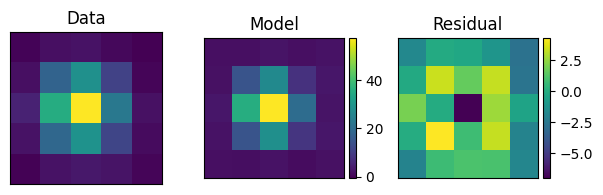

Elapsed Time for Photometry: 88.81226874799995
Starting 2.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36223231, -69.46236245)>
Setting up sim to match jw01476001007_02101_00001_nrca1_cal.fits


iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-07-11T03:15:34.398
                        MJD: 59771.13581479167

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022071001-NRCA3_FP1-0.fits
	Date (MJD):	 59770.4830
	Delta time:	 -0.6529 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022071302-NRCA3_FP1-1.fits
	Date (MJD):	 59772.6632
	Delta time:	 1.5274 days
User requested choosing OPD time closest in time to 2022-07-11T03:15:34.398, which is O2022071001-NRCA3_FP1-0.fits, delta time -0.653 days


Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022071001-NRCA3_FP1-0.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F150W
    Detector: NRCA1
    Apername: NRCA1_FULL
    Det. Pos.: (1024, 1024) 
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1130.83133665), array(1146.92815309)) pixels


    Position 1/1 centroid: (201.56015943220993, 201.88410402044425)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1921.01738481), array(1935.23196482)) pixels


    Position 1/1 centroid: (201.61849143078894, 201.51430355677192)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(353.53276977), array(1937.93602563)) pixels


    Position 1/1 centroid: (201.55111488663647, 201.74517776845153)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(342.10711397), array(367.97668353)) pixels


    Position 1/1 centroid: (201.2720012017965, 201.76136386856297)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1912.53299124), array(348.84905313)) pixels


    Position 1/1 centroid: (201.3266410104566, 201.56687745699688)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1918.28071503), array(1142.14323129)) pixels


    Position 1/1 centroid: (201.58219293062456, 201.59139093344373)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1134.51135981), array(1936.12325959)) pixels


    Position 1/1 centroid: (201.606980301233, 201.8760879439699)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(348.96560607), array(1152.98982667)) pixels


    Position 1/1 centroid: (201.45732845086877, 201.7493383330231)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1124.49552267), array(357.64935015)) pixels


    Position 1/1 centroid: (201.32222841895336, 201.788521341307)


2025-02-04 03:33:30,550 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2025-02-04 03:33:30,551 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2025-02-04 03:33:30,554 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2025-02-04 03:33:30,555 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2025-02-04 03:33:30,556 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-02-04 03:33:30,558 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2025-02-04 03:33:30,559 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2025-02-04 03:33:30,712 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('./temp_psf_dir/cal_data_asn.json',).


2025-02-04 03:33:30,725 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./temp_psf_dir
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  in_memory: True
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    tweakreg:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      save_catalogs: False


2025-02-04 03:33:30,725 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2025-02-04 03:33:31,249 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efd7959cf10>,).


2025-02-04 03:33:31,250 - stpipe.Image3Pipeline.tweakreg - INFO - Step skipped.


2025-02-04 03:33:33,279 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efd7959cf10>,).


2025-02-04 03:33:33,280 - stpipe.Image3Pipeline.skymatch - INFO - Step skipped.


2025-02-04 03:33:33,453 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efd7959cf10>,).


2025-02-04 03:33:33,453 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2025-02-04 03:33:33,627 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efd7959cf10>,).


2025-02-04 03:33:33,629 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:33:33,629 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:33:33,630 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:33:33,630 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:33:33,635 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:33:33,636 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:33:33,636 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:33:33,637 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:33:33,641 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:33:33,641 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:33:33,641 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:33:33,642 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:33:33,645 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:33:33,646 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:33:33,646 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:33:33,647 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:33:33,651 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:33:33,651 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:33:33,652 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:33:33,652 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:33:33,656 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:33:33,657 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:33:33,657 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:33:33,658 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:33:33,662 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:33:33,662 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:33:33,663 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:33:33,663 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:33:33,667 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:33:33,667 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:33:33,668 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:33:33,668 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:33:33,672 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:33:33,672 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:33:33,673 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:33:33,673 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:33:33,677 - stpipe.Image3Pipeline.resample - INFO - Driz parameter kernel: square


2025-02-04 03:33:33,677 - stpipe.Image3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2025-02-04 03:33:33,678 - stpipe.Image3Pipeline.resample - INFO - Driz parameter fillval: NAN


2025-02-04 03:33:33,678 - stpipe.Image3Pipeline.resample - INFO - Driz parameter weight_type: ivm


2025-02-04 03:33:33,678 - stpipe.Image3Pipeline.resample - INFO - Output pixel scale: 0.03122691827458939 arcsec.


2025-02-04 03:33:33,722 - stpipe.Image3Pipeline.resample - INFO - Resampling science and variance data


2025-02-04 03:33:36,534 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:36,546 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:36,546 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:39,339 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:39,350 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:39,351 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:42,132 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:42,143 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:42,143 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:44,890 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:44,901 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:44,902 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:47,673 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:47,684 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:47,685 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:50,457 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:50,468 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:50,469 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:53,268 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:53,279 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:53,280 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:56,058 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:56,070 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:56,070 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:58,828 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:58,840 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:58,840 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2025-02-04 03:33:59,257 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.342797703 -69.439587821 80.299734317 -69.467343869 80.378900278 -69.482447641 80.421891568 -69.454672069


2025-02-04 03:33:59,738 - stpipe.Image3Pipeline.resample - INFO - Saved model in ./temp_psf_dir/temp_psf_cals_i2d.fits


2025-02-04 03:33:59,739 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2025-02-04 03:33:59,909 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(3643, 3643) from temp_psf_cals_i2d.fits>,).


2025-02-04 03:33:59,910 - stpipe.Image3Pipeline.source_catalog - INFO - Step skipped.


2025-02-04 03:33:59,919 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


2025-02-04 03:33:59,919 - stpipe - INFO - Results used jwst version: 1.17.1


Finished PSF psf_photometry with median residuals of 2.15%


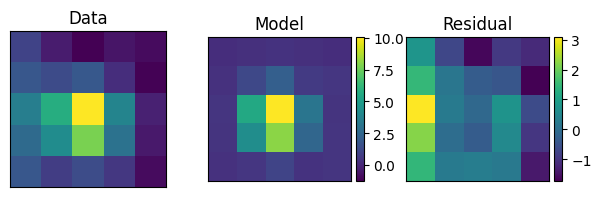

Elapsed Time for Photometry: 86.74532562700006
Starting 3.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36321461, -69.46265941)>
Setting up sim to match jw01476001007_02101_00001_nrca1_cal.fits


iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-07-11T03:15:34.398
                        MJD: 59771.13581479167

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022071001-NRCA3_FP1-0.fits
	Date (MJD):	 59770.4830
	Delta time:	 -0.6529 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022071302-NRCA3_FP1-1.fits
	Date (MJD):	 59772.6632
	Delta time:	 1.5274 days
User requested choosing OPD time closest in time to 2022-07-11T03:15:34.398, which is O2022071001-NRCA3_FP1-0.fits, delta time -0.653 days


Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022071001-NRCA3_FP1-0.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F150W
    Detector: NRCA1
    Apername: NRCA1_FULL
    Det. Pos.: (1024, 1024) 
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1141.82443533), array(1198.38684383)) pixels


    Position 1/1 centroid: (201.57303705374588, 201.88594564201324)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1931.82110977), array(1986.9857541)) pixels


    Position 1/1 centroid: (201.61259250078294, 201.50747622301395)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(364.32495794), array(1989.12793422)) pixels


    Position 1/1 centroid: (201.5494718424865, 201.7437834073172)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(353.21841235), array(419.05106296)) pixels


    Position 1/1 centroid: (201.28297377215506, 201.75957337372736)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1923.75395978), array(400.51341252)) pixels


    Position 1/1 centroid: (201.34157196654937, 201.5630448536914)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1929.29431456), array(1193.87883176)) pixels


    Position 1/1 centroid: (201.5950119856974, 201.58348961399062)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1145.31651268), array(1987.60269417)) pixels


    Position 1/1 centroid: (201.59843435533386, 201.87252221096668)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(359.92243181), array(1204.15262017)) pixels


    Position 1/1 centroid: (201.47131045801788, 201.74657810754735)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1135.66954106), array(409.03107798)) pixels


    Position 1/1 centroid: (201.3364308865235, 201.79457723493584)


2025-02-04 03:34:57,297 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2025-02-04 03:34:57,298 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2025-02-04 03:34:57,301 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2025-02-04 03:34:57,303 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2025-02-04 03:34:57,304 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-02-04 03:34:57,305 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2025-02-04 03:34:57,307 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2025-02-04 03:34:57,478 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('./temp_psf_dir/cal_data_asn.json',).


2025-02-04 03:34:57,491 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./temp_psf_dir
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  in_memory: True
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    tweakreg:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      save_catalogs: False


2025-02-04 03:34:57,491 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2025-02-04 03:34:58,025 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efdd3d56a10>,).


2025-02-04 03:34:58,026 - stpipe.Image3Pipeline.tweakreg - INFO - Step skipped.


2025-02-04 03:35:00,066 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efdd3d56a10>,).


2025-02-04 03:35:00,067 - stpipe.Image3Pipeline.skymatch - INFO - Step skipped.


2025-02-04 03:35:00,255 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efdd3d56a10>,).


2025-02-04 03:35:00,256 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2025-02-04 03:35:00,443 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efdd3d56a10>,).


2025-02-04 03:35:00,445 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:35:00,446 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:35:00,446 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:35:00,447 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:35:00,452 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:35:00,453 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:35:00,453 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:35:00,454 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:35:00,458 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:35:00,458 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:35:00,458 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:35:00,459 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:35:00,463 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:35:00,463 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:35:00,464 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:35:00,464 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:35:00,468 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:35:00,469 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:35:00,470 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:35:00,470 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:35:00,474 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:35:00,474 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:35:00,475 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:35:00,475 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:35:00,479 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:35:00,480 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:35:00,480 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:35:00,481 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:35:00,484 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:35:00,485 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:35:00,485 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:35:00,486 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:35:00,490 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:35:00,490 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:35:00,491 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:35:00,492 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:35:00,495 - stpipe.Image3Pipeline.resample - INFO - Driz parameter kernel: square


2025-02-04 03:35:00,495 - stpipe.Image3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2025-02-04 03:35:00,496 - stpipe.Image3Pipeline.resample - INFO - Driz parameter fillval: NAN


2025-02-04 03:35:00,496 - stpipe.Image3Pipeline.resample - INFO - Driz parameter weight_type: ivm


2025-02-04 03:35:00,497 - stpipe.Image3Pipeline.resample - INFO - Output pixel scale: 0.03122691827458939 arcsec.


2025-02-04 03:35:00,542 - stpipe.Image3Pipeline.resample - INFO - Resampling science and variance data


2025-02-04 03:35:03,410 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:03,422 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:03,423 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:06,230 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:06,241 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:06,242 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:09,049 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:09,061 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:09,061 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:11,825 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:11,836 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:11,837 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:14,609 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:14,620 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:14,621 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:17,423 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:17,434 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:17,435 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:20,242 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:20,253 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:20,253 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:23,072 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:23,084 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:23,085 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:25,880 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:25,891 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:25,891 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2025-02-04 03:35:26,337 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.342797703 -69.439587821 80.299734317 -69.467343869 80.378900278 -69.482447641 80.421891568 -69.454672069


2025-02-04 03:35:26,893 - stpipe.Image3Pipeline.resample - INFO - Saved model in ./temp_psf_dir/temp_psf_cals_i2d.fits


2025-02-04 03:35:26,894 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2025-02-04 03:35:27,072 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(3643, 3643) from temp_psf_cals_i2d.fits>,).


2025-02-04 03:35:27,073 - stpipe.Image3Pipeline.source_catalog - INFO - Step skipped.


2025-02-04 03:35:27,082 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


2025-02-04 03:35:27,083 - stpipe - INFO - Results used jwst version: 1.17.1


Finished PSF psf_photometry with median residuals of 0.35%


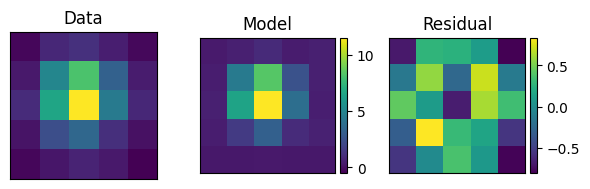

Elapsed Time for Photometry: 87.379823966
Starting 4.0  of 4 : <SkyCoord (ICRS): (ra, dec) in deg
    (80.36222499, -69.46259042)>
Setting up sim to match jw01476001007_02101_00001_nrca1_cal.fits


iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-07-11T03:15:34.398
                        MJD: 59771.13581479167

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022071001-NRCA3_FP1-0.fits
	Date (MJD):	 59770.4830
	Delta time:	 -0.6529 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022071302-NRCA3_FP1-1.fits
	Date (MJD):	 59772.6632
	Delta time:	 1.5274 days
User requested choosing OPD time closest in time to 2022-07-11T03:15:34.398, which is O2022071001-NRCA3_FP1-0.fits, delta time -0.653 days
Importing and format-converting OPD from ./webbpsf-data/webbpsf-data/MAST_JWST_WSS_OPDs/O2022071001-NRCA3_FP1-0.fits


Backing out SI WFE and OTE field dependence at the WF sensing field point



Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F150W
    Detector: NRCA1
    Apername: NRCA1_FULL
    Det. Pos.: (1024, 1024) 
    Image plane mask: None
    Pupil plane mask: None
    

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1153.99487079), array(1159.29263729)) pixels


    Position 1/1 centroid: (201.56463155992182, 201.88280411723474)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1944.24611879), array(1947.80227115)) pixels


    Position 1/1 centroid: (201.61797698319634, 201.50257112411626)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(376.46659295), array(1950.31790816)) pixels


    Position 1/1 centroid: (201.55392143227127, 201.74305262074068)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(365.15354402), array(380.09743533)) pixels


    Position 1/1 centroid: (201.2743514079384, 201.7508588859237)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1935.90537062), array(361.19673059)) pixels


    Position 1/1 centroid: (201.33094458355188, 201.5600391718873)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1941.58612657), array(1154.60816439)) pixels


    Position 1/1 centroid: (201.5860364249192, 201.57997249828063)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1157.60568189), array(1948.60037878)) pixels


    Position 1/1 centroid: (201.60369579506576, 201.8718653462744)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(371.96195965), array(1165.25021073)) pixels


    Position 1/1 centroid: (201.46142236440053, 201.74422372983796)

Running instrument: NIRCam, filter: F150W
  Running detector: NRCA1
    Position 1/1: (array(1147.71699544), array(369.8863577)) pixels


    Position 1/1 centroid: (201.32613046894144, 201.7890969381587)


2025-02-04 03:36:24,660 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2025-02-04 03:36:24,661 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2025-02-04 03:36:24,664 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2025-02-04 03:36:24,665 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2025-02-04 03:36:24,667 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-02-04 03:36:24,668 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2025-02-04 03:36:24,670 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2025-02-04 03:36:24,833 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('./temp_psf_dir/cal_data_asn.json',).


2025-02-04 03:36:24,846 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./temp_psf_dir
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  in_memory: True
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    tweakreg:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: True
      input_dir: ''
      save_catalogs: False


2025-02-04 03:36:24,846 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2025-02-04 03:36:25,380 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efd795de2d0>,).


2025-02-04 03:36:25,380 - stpipe.Image3Pipeline.tweakreg - INFO - Step skipped.


2025-02-04 03:36:27,432 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efd795de2d0>,).


2025-02-04 03:36:27,433 - stpipe.Image3Pipeline.skymatch - INFO - Step skipped.


2025-02-04 03:36:27,627 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efd795de2d0>,).


2025-02-04 03:36:27,627 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2025-02-04 03:36:27,819 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<jwst.datamodels.library.ModelLibrary object at 0x7efd795de2d0>,).


2025-02-04 03:36:27,821 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:36:27,821 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:36:27,822 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:36:27,822 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:36:27,827 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:36:27,828 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:36:27,829 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:36:27,829 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:36:27,833 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:36:27,833 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:36:27,834 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:36:27,834 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:36:27,838 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:36:27,839 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:36:27,839 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:36:27,840 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:36:27,844 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:36:27,844 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:36:27,845 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:36:27,845 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:36:27,849 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:36:27,849 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:36:27,850 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:36:27,850 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:36:27,854 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:36:27,854 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:36:27,855 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:36:27,855 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:36:27,859 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:36:27,860 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:36:27,860 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:36:27,860 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:36:27,864 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'err'


2025-02-04 03:36:27,865 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_rnoise'


2025-02-04 03:36:27,865 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_poisson'


2025-02-04 03:36:27,866 - stpipe.Image3Pipeline.resample - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'var_flat'


2025-02-04 03:36:27,869 - stpipe.Image3Pipeline.resample - INFO - Driz parameter kernel: square


2025-02-04 03:36:27,870 - stpipe.Image3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2025-02-04 03:36:27,870 - stpipe.Image3Pipeline.resample - INFO - Driz parameter fillval: NAN


2025-02-04 03:36:27,870 - stpipe.Image3Pipeline.resample - INFO - Driz parameter weight_type: ivm


2025-02-04 03:36:27,871 - stpipe.Image3Pipeline.resample - INFO - Output pixel scale: 0.03122691827458939 arcsec.


2025-02-04 03:36:27,917 - stpipe.Image3Pipeline.resample - INFO - Resampling science and variance data


2025-02-04 03:36:30,748 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:30,760 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:30,760 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:33,543 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:33,555 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:33,555 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:36,362 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:36,373 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:36,374 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001007_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:39,175 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:39,187 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:39,187 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00001_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:41,997 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:42,009 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:42,010 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00002_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:44,782 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:44,794 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:44,794 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00003_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:47,576 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:47,588 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:47,588 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00004_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:50,371 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:50,384 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:50,384 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00005_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:53,228 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_rnoise' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:53,241 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_poisson' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:53,241 - stpipe.Image3Pipeline.resample - WARNING - Data shape mismatch for 'var_flat' for model 'jw01476001008_02101_00006_nrca1_cal.fits'. Skipping ...


2025-02-04 03:36:53,689 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.342797703 -69.439587821 80.299734317 -69.467343869 80.378900278 -69.482447641 80.421891568 -69.454672069


2025-02-04 03:36:54,170 - stpipe.Image3Pipeline.resample - INFO - Saved model in ./temp_psf_dir/temp_psf_cals_i2d.fits


2025-02-04 03:36:54,170 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2025-02-04 03:36:54,374 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(3643, 3643) from temp_psf_cals_i2d.fits>,).


2025-02-04 03:36:54,375 - stpipe.Image3Pipeline.source_catalog - INFO - Step skipped.


2025-02-04 03:36:54,384 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


2025-02-04 03:36:54,385 - stpipe - INFO - Results used jwst version: 1.17.1


Finished PSF psf_photometry with median residuals of 0.10%


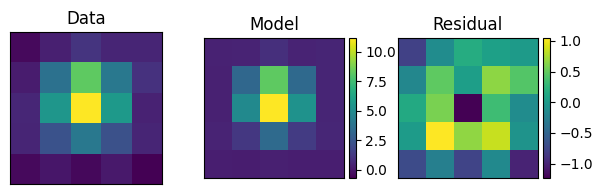

Elapsed Time for Photometry: 87.02710828599993


In [39]:
# Now Loop Through All Stars and Build Photometry Table
counter = 0.
badindex = []

for source_location in skycoords:
    tic = time.perf_counter()
    print('Starting', counter+1., ' of', len(skycoords), ':', source_location)
    psf3 = space_phot.get_jwst3_psf(jwst_obs, jwst3_obs, source_location, num_psfs=4)
    jwst3_obs.psf_photometry(
        psf3,
        source_location,
        bounds={
            'flux': [-1000, 10000],
            'centroid': [-2, 2],
            'bkg': [0, 50]
        },
        fit_width=5,
        fit_bkg=True,
        fit_flux=True
    )

    jwst3_obs.plot_psf_fit()
    plt.show()

    ra = jwst3_obs.psf_result.phot_cal_table['ra'][0]
    dec = jwst3_obs.psf_result.phot_cal_table['dec'][0]
    mag_lvl3psf = jwst3_obs.psf_result.phot_cal_table['mag'][0]
    magerr_lvl3psf = jwst3_obs.psf_result.phot_cal_table['magerr'][0]

    if counter == 0:
        df = pd.DataFrame(np.array([[ra, dec, mag_lvl3psf, magerr_lvl3psf]]), columns=['ra', 'dec', 'mag', 'magerr'])
    else:
        df = pd.concat([df, pd.DataFrame(np.array([[ra, dec, mag_lvl3psf, magerr_lvl3psf]]))], ignore_index=True)
    counter = counter + 1.
    toc = time.perf_counter()
    print("Elapsed Time for Photometry:", toc - tic)

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>